# Import everything

In [1]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import math
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz
from itertools import combinations
import openpyxl

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read powers

In [2]:
df_power = pd.read_csv('164-d1-powers.csv')
df_power.shape

(1285440, 17)

In [4]:
# Dataset 1
def_values_power = {
    'ArtifactRemoved': True, 
    'EEG': 'Raw', 
    'Resampled': False, 
    'Filter': 'Butterworth', 
    'Time': -750, 
    'Method': 'Welch'
}
hue_order_power = {
    'ArtifactRemoved': [True, False], 
    'EEG': ['Raw', 'Hjorth', 'Averaged'], 
    'Resampled': [True, False], 
    'Filter': ['Blackmann-Harris', 'Butterworth'], 
    'Time': [-150, -750], 
    'Method': ['FFT', 'Welch', 'Burg']
}
def_values_phase = {
    'ArtifactRemoved': False, 
    'EEG': 'Raw',
    'Filter': 'Butterworth', 
}

# Dataset 2
def_values_power_d2 = {
    'EEG': 'Raw', 
    'Filter': 'Butterworth', 
    'Time': -750, 
    'Method': 'Welch'
}
hue_order_power_d2 = {
    'EEG': ['Raw', 'Hjorth', 'Average'], 
    'Filter': ['Blackmann-Harris', 'Butterworth'], 
    'Time': [-150, -750], 
    'Method': ['FFT', 'Welch', 'Burg']
}
def_values_phase_d2 = {
    'EEG': 'Raw',
    'Filter': 'Butterworth', 
}

In [5]:
features = {}
for key, _ in def_values_power.items():
    features[key] = list(df_power[key].unique())

df_new = []
keys = list(features.keys())
for sub in tqdm(df_power['sub'].unique()):
    df = df_power[df_power['sub'] == sub]
    df2 = df
    for value0 in features[keys[0]]:
        for value1 in features[keys[1]]:
            for value2 in features[keys[2]]:
                for value3 in features[keys[3]]:
                    for value4 in features[keys[4]]:
                        for value5 in features[keys[5]]:
                            for value6 in ['Theta', 'Mu', 'Beta', 'Gamma']:
                                df3 = df2[df2[keys[0]] == value0]
                                df3 = df3[df3[keys[1]] == value1]
                                df3 = df3[df3[keys[2]] == value2]
                                df3 = df3[df3[keys[3]] == value3]
                                df3 = df3[df3[keys[4]] == value4]
                                df3 = df3[df3[keys[5]] == value5]
                                df3 = df3[df3['Band'] == value6]
                                i = 1
                                for idx, row in df3.iterrows():
                                    row['trial_abs'] = i
                                    i = i + 1
                                    df_new.append(row)    
df_new = pd.DataFrame(df_new)
print(df_new.shape)
df_new.head()


(1285440, 17)


Unnamed: 0  ArtifactRemoved   Band  EEG            Filter Method  \
0             0            False  Theta  Raw  Blackmann-Harris    FFT   
96           96            False  Theta  Raw  Blackmann-Harris    FFT   
192         192            False  Theta  Raw  Blackmann-Harris    FFT   
288         288            False  Theta  Raw  Blackmann-Harris    FFT   
384         384            False  Theta  Raw  Blackmann-Harris    FFT   

         Power  Resampled  Time    exp  mep_area  mep_duration  mep_latency  \
0    41.365676       True  -150  exp01  0.006262        0.1634       0.2212   
96   37.995238       True  -150  exp01  0.005301        0.1558       0.2208   
192  31.328897       True  -150  exp01  0.004402        0.1885       0.2217   
288  30.255986       True  -150  exp01  0.002237        0.1334       0.2222   
384  31.762834       True  -150  exp01  0.004953        0.1610       0.2212   

              run    sub  trial  trial_abs  
0    SP 110RMT r1  sub02      0          1  
96   SP 110RMT r1  sub02      1          2  
192  SP 110RMT r1  sub02      2          3  
288  SP 110RMT r1  sub02      3          4  
384  SP 110RMT r1  sub02      4          5

In [6]:
df_new = df_new.reset_index()
df_new = df_new.drop(['Unnamed: 0'], axis=1)
df_new.head()

index  ArtifactRemoved   Band  EEG            Filter Method      Power  \
0      0            False  Theta  Raw  Blackmann-Harris    FFT  41.365676   
1     96            False  Theta  Raw  Blackmann-Harris    FFT  37.995238   
2    192            False  Theta  Raw  Blackmann-Harris    FFT  31.328897   
3    288            False  Theta  Raw  Blackmann-Harris    FFT  30.255986   
4    384            False  Theta  Raw  Blackmann-Harris    FFT  31.762834   

   Resampled  Time    exp  mep_area  mep_duration  mep_latency           run  \
0       True  -150  exp01  0.006262        0.1634       0.2212  SP 110RMT r1   
1       True  -150  exp01  0.005301        0.1558       0.2208  SP 110RMT r1   
2       True  -150  exp01  0.004402        0.1885       0.2217  SP 110RMT r1   
3       True  -150  exp01  0.002237        0.1334       0.2222  SP 110RMT r1   
4       True  -150  exp01  0.004953        0.1610       0.2212  SP 110RMT r1   

     sub  trial  trial_abs  
0  sub02      0          1  
1  sub02      1          2  
2  sub02      2          3  
3  sub02      3          4  
4  sub02      4          5

In [7]:
df_new.to_csv('164-d1-powers.csv')

# Read phases

In [8]:
df_phase = pd.read_csv('164-d1-phases.csv')
df_phase.shape

(107120, 13)

In [9]:
features = {}
for key, _ in def_values_phase.items():
    features[key] = list(df_power[key].unique())
features

{'ArtifactRemoved': [False, True],
 'EEG': ['Raw', 'Hjorth', 'Averaged'],
 'Filter': ['Blackmann-Harris', 'Butterworth']}

In [10]:
df_new = []
keys = list(features.keys())
for sub in tqdm(df_phase['sub'].unique()):
    df = df_phase[df_phase['sub'] == sub]
    df2 = df
    for value0 in features[keys[0]]:
        for value1 in features[keys[1]]:
            for value2 in features[keys[2]]:
                for value4 in ['Theta', 'Mu', 'Beta', 'Gamma']:
                    df3 = df2[df2[keys[0]] == value0]
                    df3 = df3[df3[keys[1]] == value1]
                    df3 = df3[df3[keys[2]] == value2]
                    df3 = df3[df3['Band'] == value4]
                    i = 1
                    for idx, row in df3.iterrows():
                        row['trial_abs'] = i
                        i = i + 1
                        df_new.append(row)    
df_new = pd.DataFrame(df_new)
print(df_new.shape)
df_new.head()


(107120, 14)


Unnamed: 0  ArtifactRemoved   Band  EEG            Filter       Phase  \
0            0            False  Theta  Raw  Blackmann-Harris   57.476078   
8            8            False  Theta  Raw  Blackmann-Harris  237.502984   
16          16            False  Theta  Raw  Blackmann-Harris   57.475986   
24          24            False  Theta  Raw  Blackmann-Harris   57.446193   
32          32            False  Theta  Raw  Blackmann-Harris   57.525575   

      exp  mep_area  mep_duration  mep_latency           run    sub  trial  \
0   exp01  0.006262        0.1634       0.2212  SP 110RMT r1  sub02      0   
8   exp01  0.005301        0.1558       0.2208  SP 110RMT r1  sub02      1   
16  exp01  0.004402        0.1885       0.2217  SP 110RMT r1  sub02      2   
24  exp01  0.002237        0.1334       0.2222  SP 110RMT r1  sub02      3   
32  exp01  0.004953        0.1610       0.2212  SP 110RMT r1  sub02      4   

    trial_abs  
0           1  
8           2  
16          3  
24          4  
32          5

In [11]:
df_new = df_new.reset_index()
df_new = df_new.drop(['Unnamed: 0'], axis=1)
df_new.head()

index  ArtifactRemoved   Band  EEG            Filter       Phase    exp  \
0      0            False  Theta  Raw  Blackmann-Harris   57.476078  exp01   
1      8            False  Theta  Raw  Blackmann-Harris  237.502984  exp01   
2     16            False  Theta  Raw  Blackmann-Harris   57.475986  exp01   
3     24            False  Theta  Raw  Blackmann-Harris   57.446193  exp01   
4     32            False  Theta  Raw  Blackmann-Harris   57.525575  exp01   

   mep_area  mep_duration  mep_latency           run    sub  trial  trial_abs  
0  0.006262        0.1634       0.2212  SP 110RMT r1  sub02      0          1  
1  0.005301        0.1558       0.2208  SP 110RMT r1  sub02      1          2  
2  0.004402        0.1885       0.2217  SP 110RMT r1  sub02      2          3  
3  0.002237        0.1334       0.2222  SP 110RMT r1  sub02      3          4  
4  0.004953        0.1610       0.2212  SP 110RMT r1  sub02      4          5

In [12]:
df_new.to_csv('164-d1-phases.csv')

# Dataset 1

In [13]:
df_power = pd.read_csv('164-d1-powers.csv')
df_phase = pd.read_csv('164-d1-phases.csv')

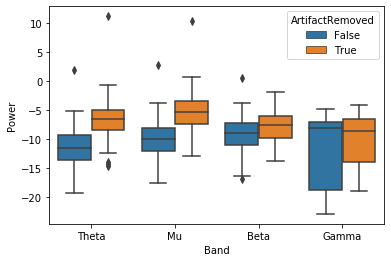

In [14]:
df_power2 = df_power
df_power2 = df_power2[df_power2['EEG'] == 'Hjorth']
df_power2 = df_power2[df_power2['Resampled'] == False]
df_power2 = df_power2[df_power2['Filter'] == 'Butterworth']
df_power2 = df_power2[df_power2['Time'] == -750]
df_power2 = df_power2[df_power2['Method'] == 'Welch']
df_power2 = df_power2[df_power2['sub'] == 'sub21']
sns.boxplot(x='Band', y='Power', hue='ArtifactRemoved', data=df_power2)

## Violin plots for power

--------------
ArtifactRemoved
--------------
Performing EEG = Raw for constant ArtifactRemoved, shape = (28800, 16)
Performing Resampled = False for constant ArtifactRemoved, shape = (14400, 16)
Performing Filter = Butterworth for constant ArtifactRemoved, shape = (7200, 16)
Performing Time = -750 for constant ArtifactRemoved, shape = (3600, 16)
Performing Method = Welch for constant ArtifactRemoved, shape = (1200, 16)
--------------
EEG
--------------
Performing ArtifactRemoved = True for constant EEG, shape = (43200, 16)
Performing Resampled = False for constant EEG, shape = (21600, 16)
Performing Filter = Butterworth for constant EEG, shape = (10800, 16)
Performing Time = -750 for constant EEG, shape = (5400, 16)
Performing Method = Welch for constant EEG, shape = (1800, 16)
--------------
Resampled
--------------
Performing ArtifactRemoved = True for constant Resampled, shape = (43200, 16)
Performing EEG = Raw for constant Resampled, shape = (14400, 16)
Performing Filter = Butterw

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


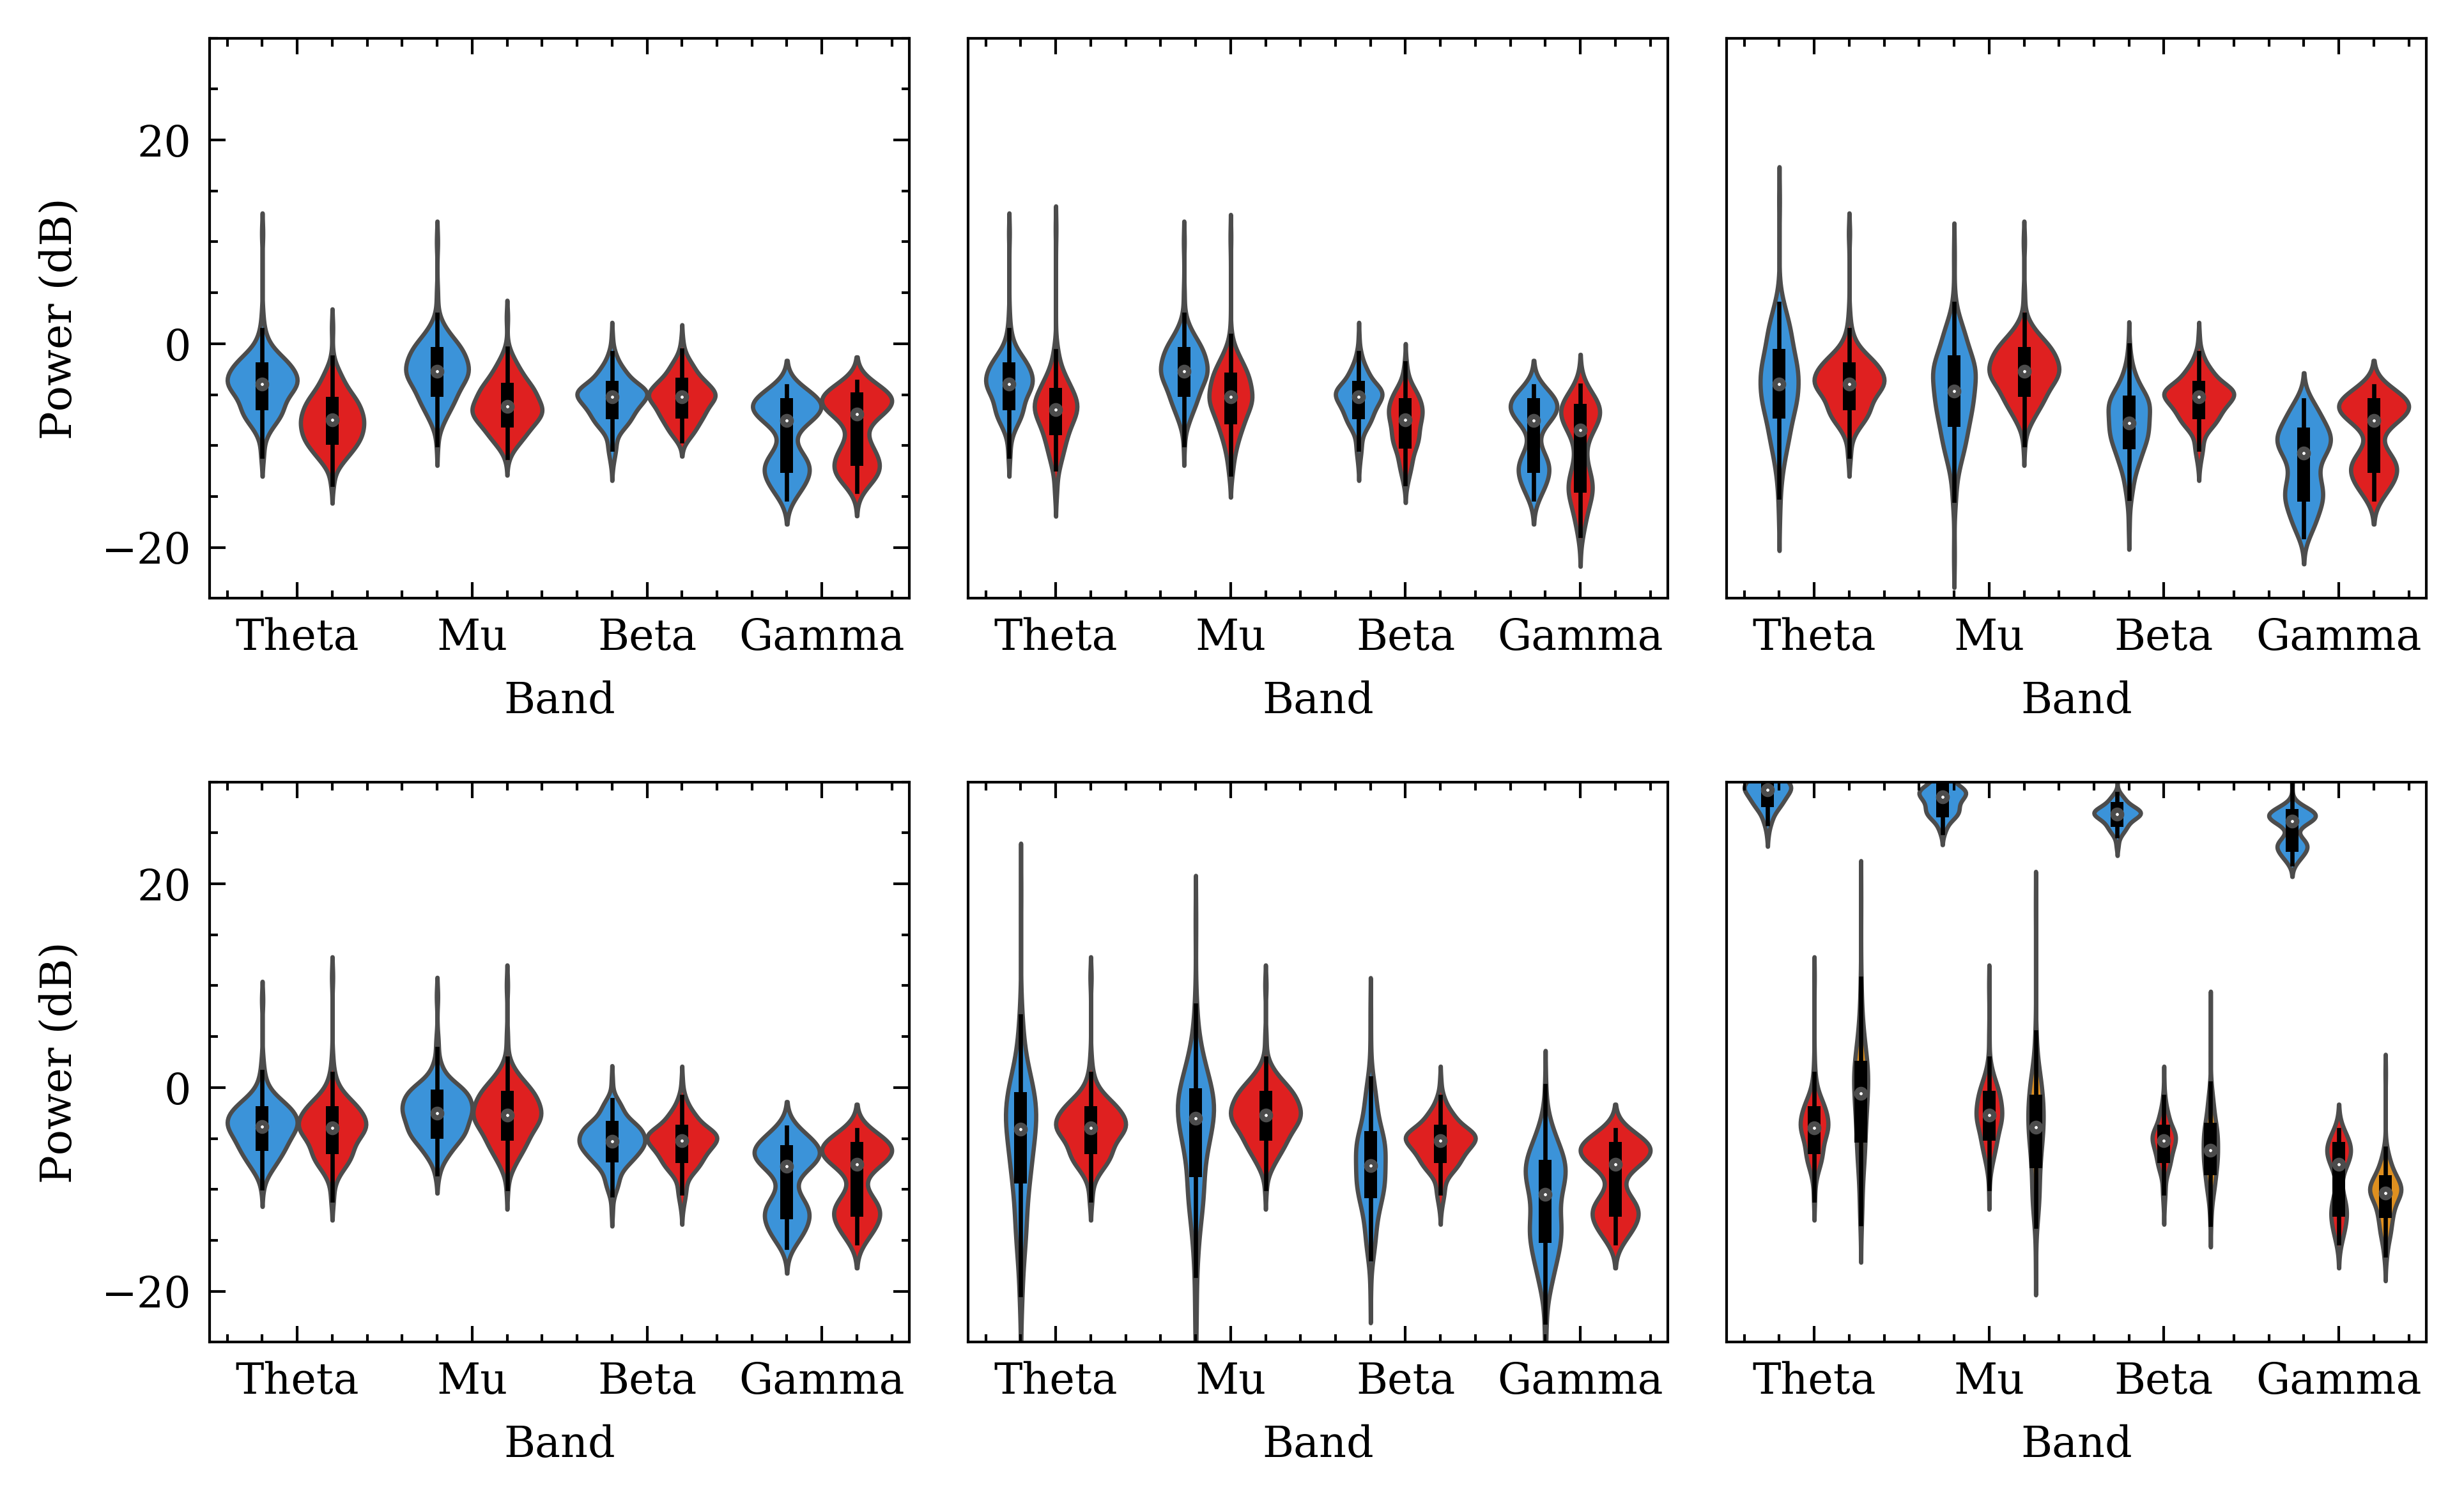

In [45]:
df_power2 = df_power[df_power['sub'] == 'sub21']
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(2,3,figsize=(6.5,4))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power.keys())):    
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        sns.violinplot(x="Band", y="Power", hue=variable, data=df_power3, ax=axs[i, j], fliersize=0, hue_order=hue_order_power[variable])
        axs[i, j].set_ylim([-25,30])
        plt.setp(axs[i, j].lines, color='k')
        axs[i, j].get_legend().remove()
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
            axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 2:
            j = 0
            i = i + 1

    plt.tight_layout()

## PSDs across trials

--------------
ArtifactRemoved
--------------
Performing EEG = Raw for constant ArtifactRemoved, shape = (7200, 18)
Performing Resampled = False for constant ArtifactRemoved, shape = (3600, 18)
Performing Filter = Butterworth for constant ArtifactRemoved, shape = (1800, 18)
Performing Time = -750 for constant ArtifactRemoved, shape = (900, 18)
Performing Method = Welch for constant ArtifactRemoved, shape = (300, 18)
--------------
EEG
--------------
Performing ArtifactRemoved = True for constant EEG, shape = (10800, 18)
Performing Resampled = False for constant EEG, shape = (5400, 18)
Performing Filter = Butterworth for constant EEG, shape = (2700, 18)
Performing Time = -750 for constant EEG, shape = (1350, 18)
Performing Method = Welch for constant EEG, shape = (450, 18)
--------------
Resampled
--------------
Performing ArtifactRemoved = True for constant Resampled, shape = (10800, 18)
Performing EEG = Raw for constant Resampled, shape = (3600, 18)
Performing Filter = Butterworth for

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


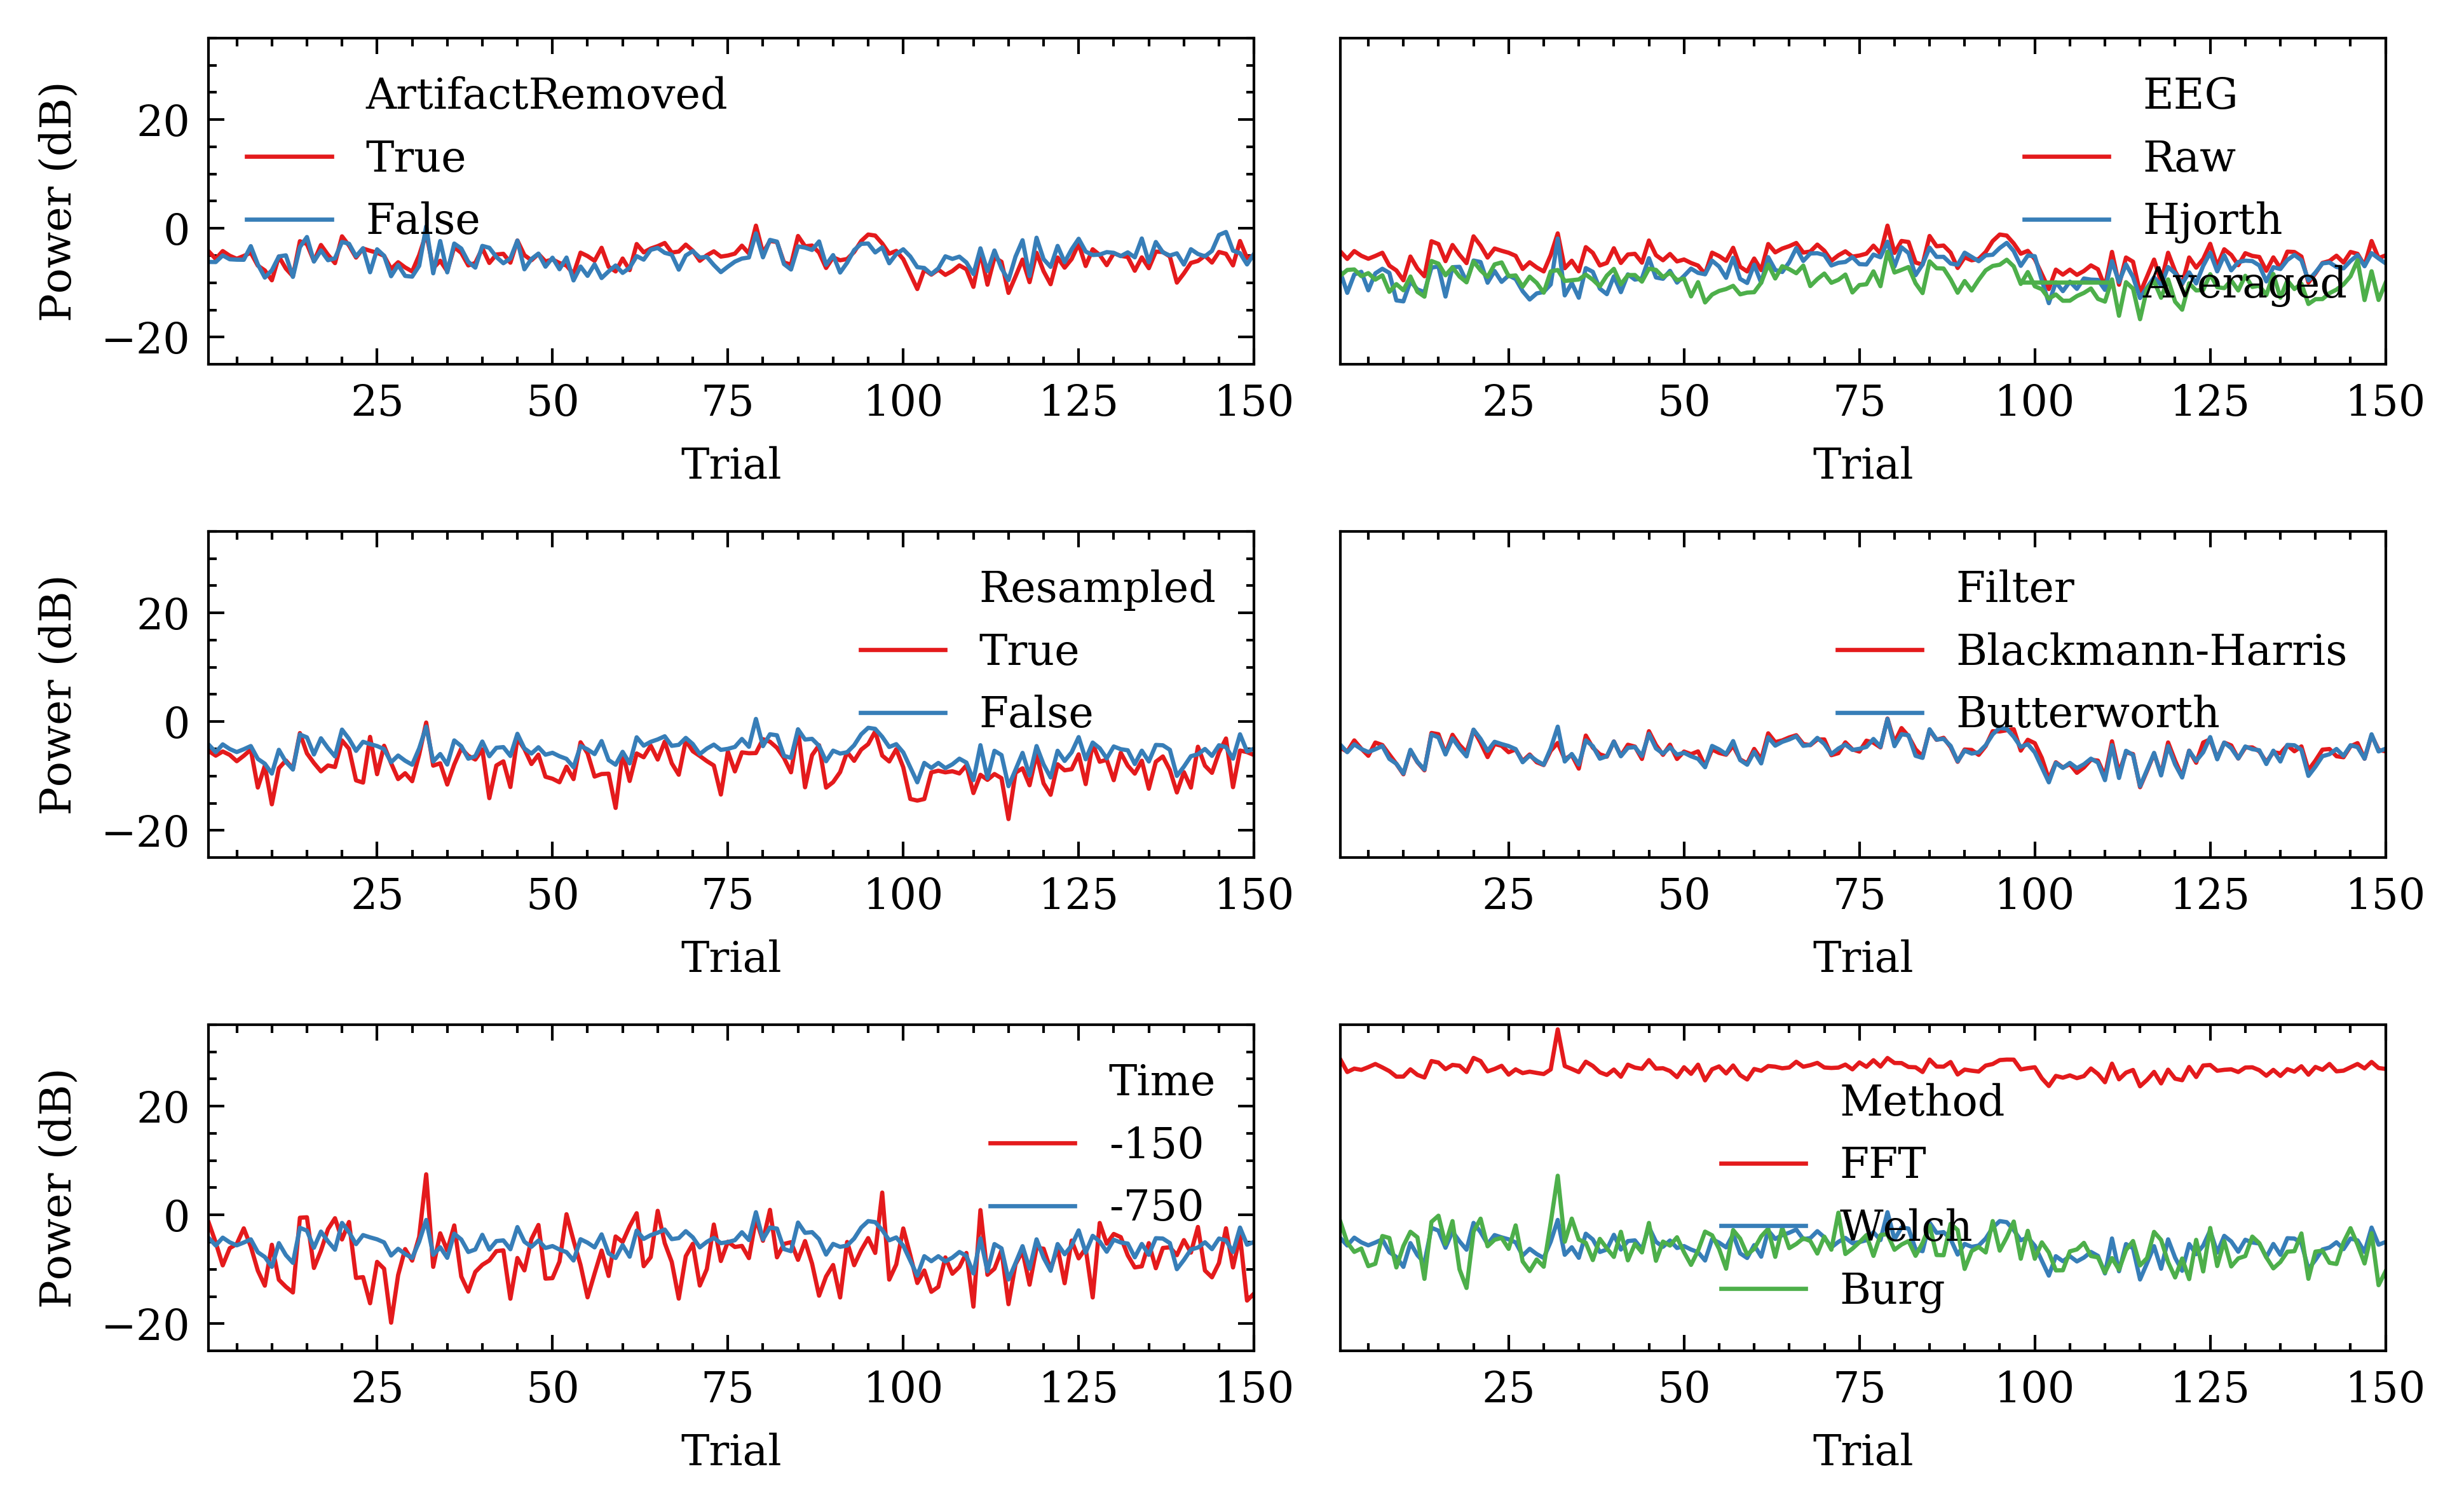

In [15]:
df_power2 = df_power[df_power['sub'] == 'sub21']
df_power2 = df_power2[df_power2['Band'] == 'Beta']
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(3, 2, figsize=(6.5,4))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power.keys())):
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        df_power3 = df_power3[['trial_abs', 'Power', variable]]
        sns.lineplot(x="trial_abs", y="Power", hue=variable, data=df_power3, ax=axs[i, j], hue_order=hue_order_power[variable], palette=sns.color_palette("Set1", df_power3[variable].nunique()))
        axs[i, j].set_ylim([-25,35])
        # plt.setp(axs[i, j].lines, color='k')
        # axs[i, j].get_legend().remove()
        axs[i,j].set_xlabel('Trial')
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
            axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 1:
            j = 0
            i = i + 1

    plt.tight_layout()

## Box plots of PSD

--------------
ArtifactRemoved
--------------
Performing EEG = Raw for constant ArtifactRemoved, shape = (28800, 18)
Performing Resampled = False for constant ArtifactRemoved, shape = (14400, 18)
Performing Filter = Butterworth for constant ArtifactRemoved, shape = (7200, 18)
Performing Time = -750 for constant ArtifactRemoved, shape = (3600, 18)
Performing Method = Welch for constant ArtifactRemoved, shape = (1200, 18)
--------------
EEG
--------------
Performing ArtifactRemoved = True for constant EEG, shape = (43200, 18)
Performing Resampled = False for constant EEG, shape = (21600, 18)
Performing Filter = Butterworth for constant EEG, shape = (10800, 18)
Performing Time = -750 for constant EEG, shape = (5400, 18)
Performing Method = Welch for constant EEG, shape = (1800, 18)
--------------
Resampled
--------------
Performing ArtifactRemoved = True for constant Resampled, shape = (43200, 18)
Performing EEG = Raw for constant Resampled, shape = (14400, 18)
Performing Filter = Butterw

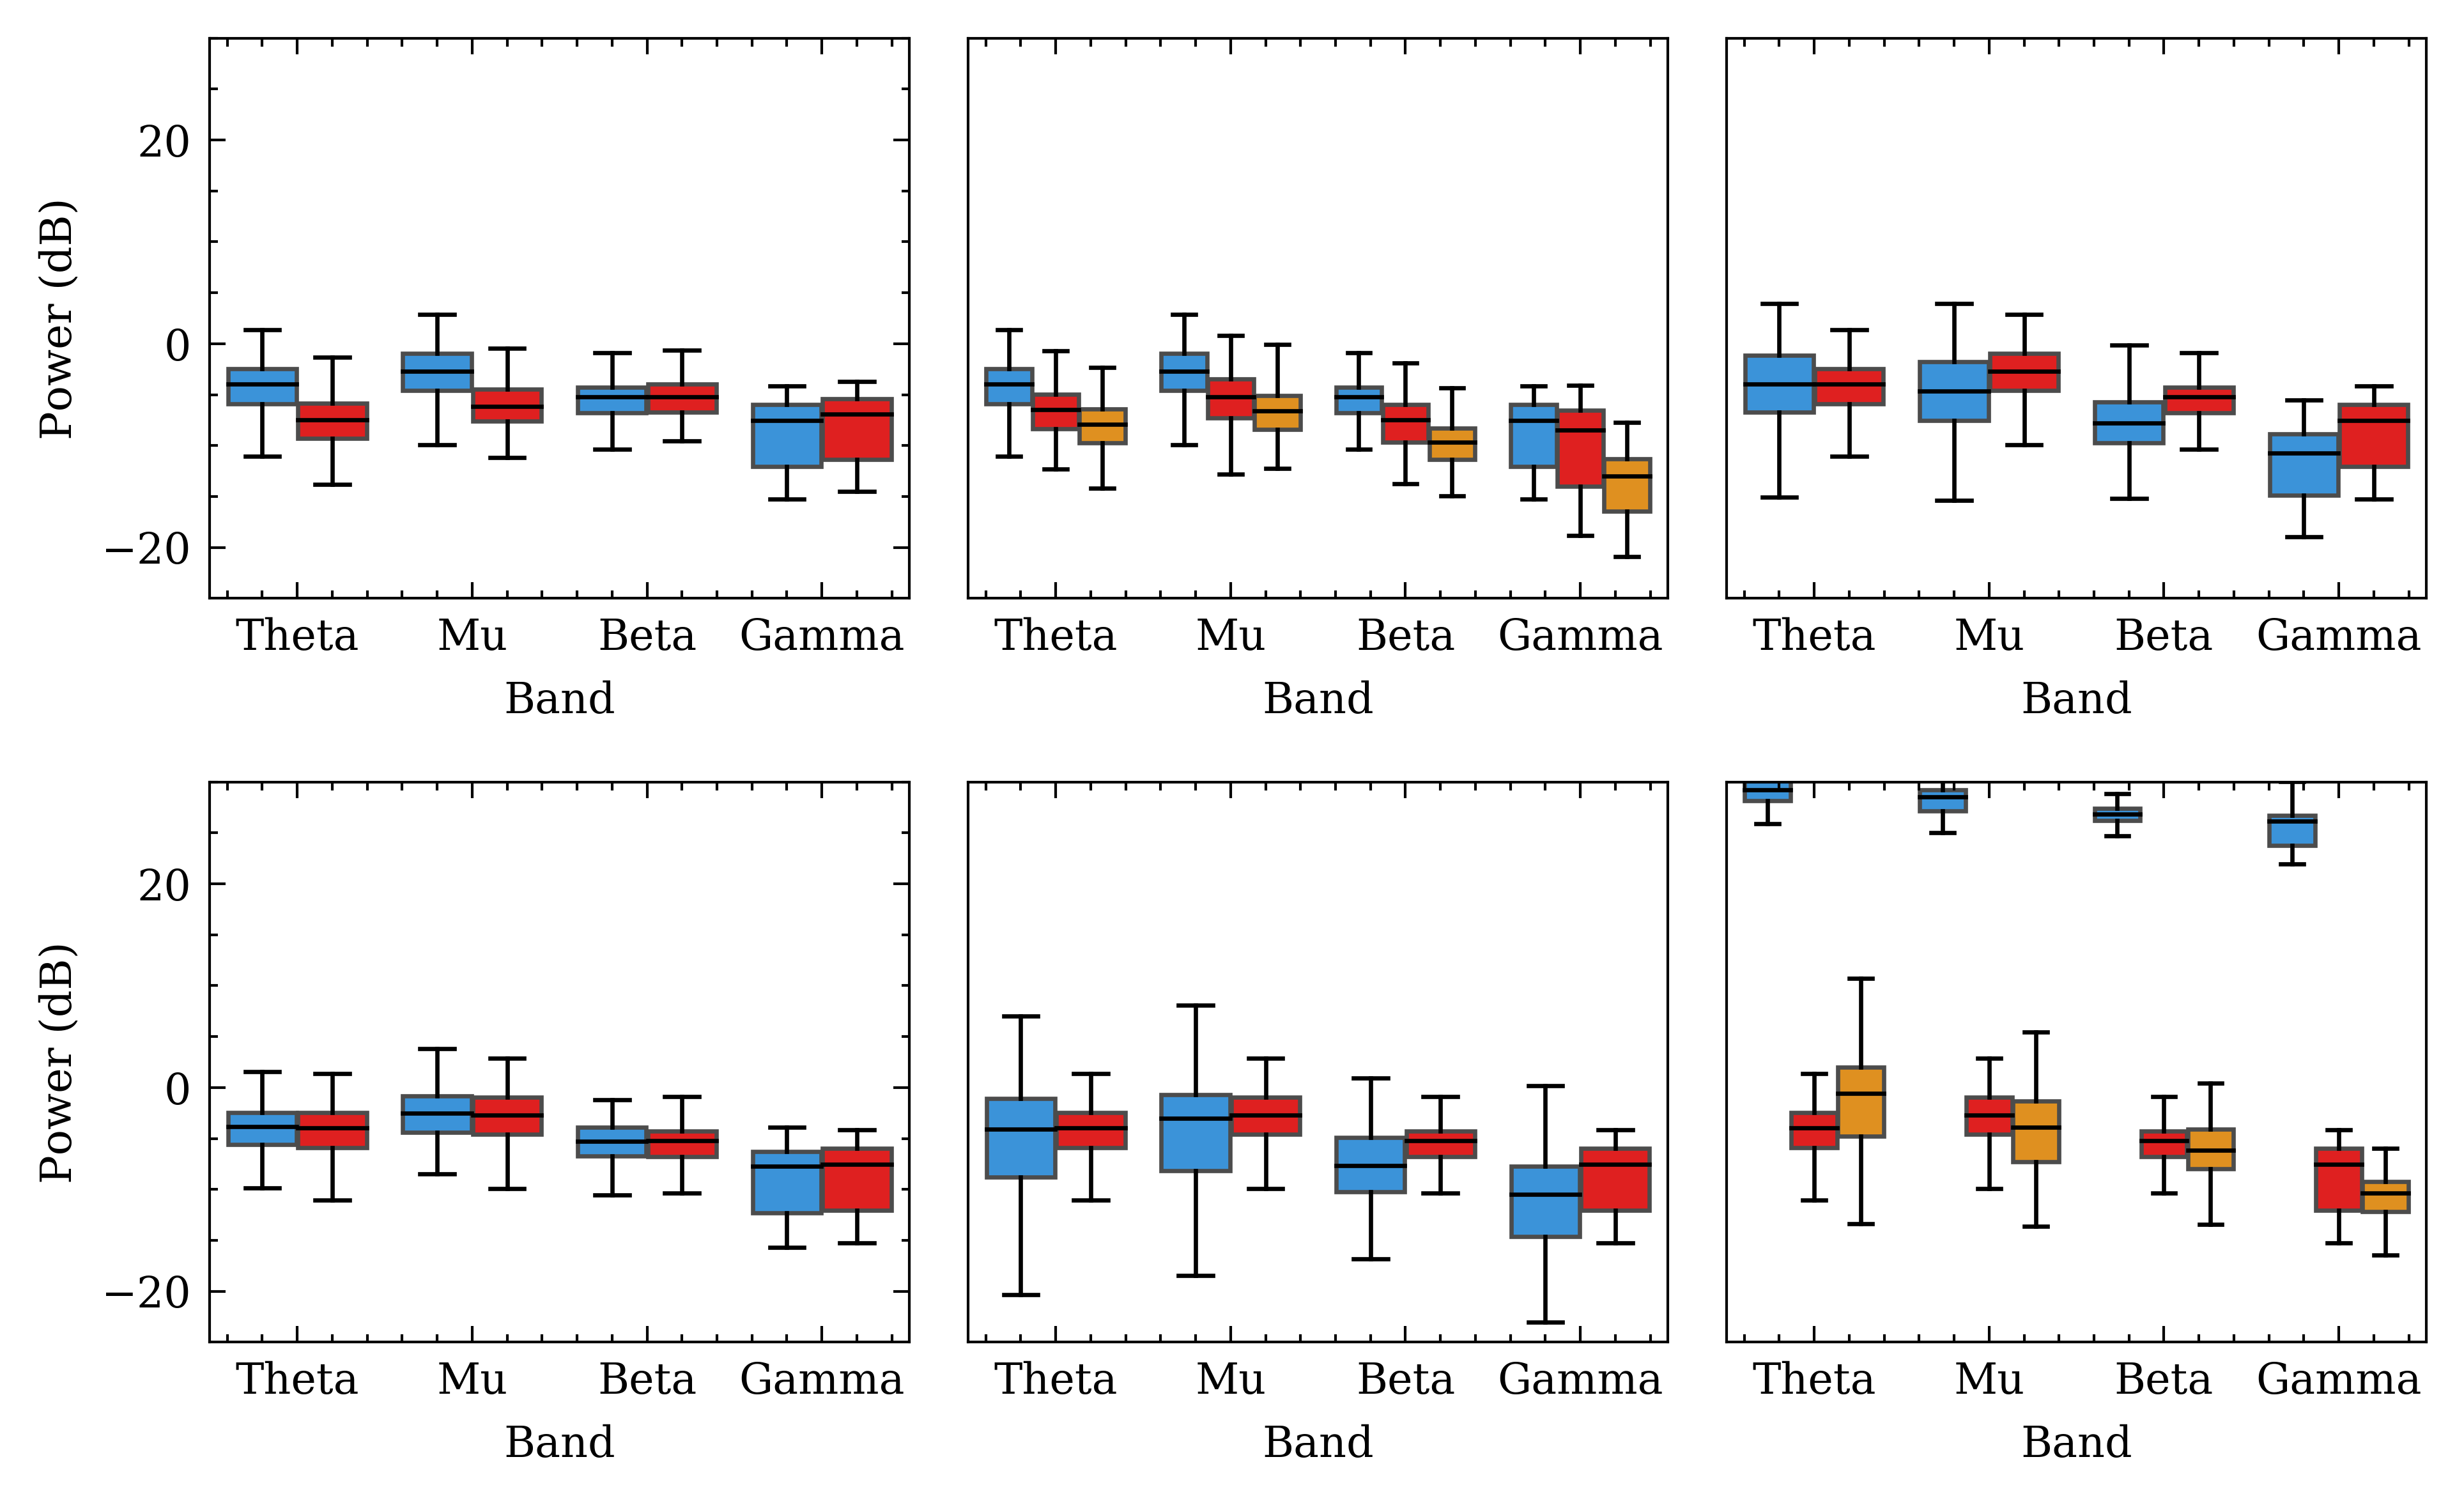

In [16]:
df_power2 = df_power[df_power['sub'] == 'sub21']
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(2,3,figsize=(6.5,4))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power.keys())):    
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        sns.boxplot(x="Band", y="Power", hue=variable, data=df_power3, ax=axs[i, j], fliersize=0, hue_order=hue_order_power[variable])
        axs[i, j].set_ylim([-25,30])
        plt.setp(axs[i, j].lines, color='k')
        axs[i, j].get_legend().remove()
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
            axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 2:
            j = 0
            i = i + 1

    plt.tight_layout()

# Interaction plot - power

Plotting in (0, 0): ('Artifact removed', 'EEG'), shape: (900, 25), unique1: [ True False], unique2: ['Average' 'Raw' 'Hjorth']
Plotting in (0, 1): ('Artifact removed', 'Resampled'), shape: (600, 25), unique1: [ True False], unique2: [ True False]
Plotting in (0, 2): ('Artifact removed', 'Filter'), shape: (600, 25), unique1: [ True False], unique2: ['Blackmann-Harris' 'Butterworth']
Plotting in (0, 3): ('Artifact removed', 'Time'), shape: (600, 25), unique1: [ True False], unique2: [-750 -150]
Plotting in (0, 4): ('Artifact removed', 'Method'), shape: (900, 25), unique1: [ True False], unique2: ['Burg' 'FFT' 'Welch']
Plotting in (1, 0): ('EEG', 'Resampled'), shape: (900, 25), unique1: ['Average' 'Raw' 'Hjorth'], unique2: [ True False]
Plotting in (1, 1): ('EEG', 'Filter'), shape: (900, 25), unique1: ['Average' 'Raw' 'Hjorth'], unique2: ['Blackmann-Harris' 'Butterworth']
Plotting in (1, 2): ('EEG', 'Time'), shape: (900, 25), unique1: ['Average' 'Raw' 'Hjorth'], unique2: [-750 -150]
Plott

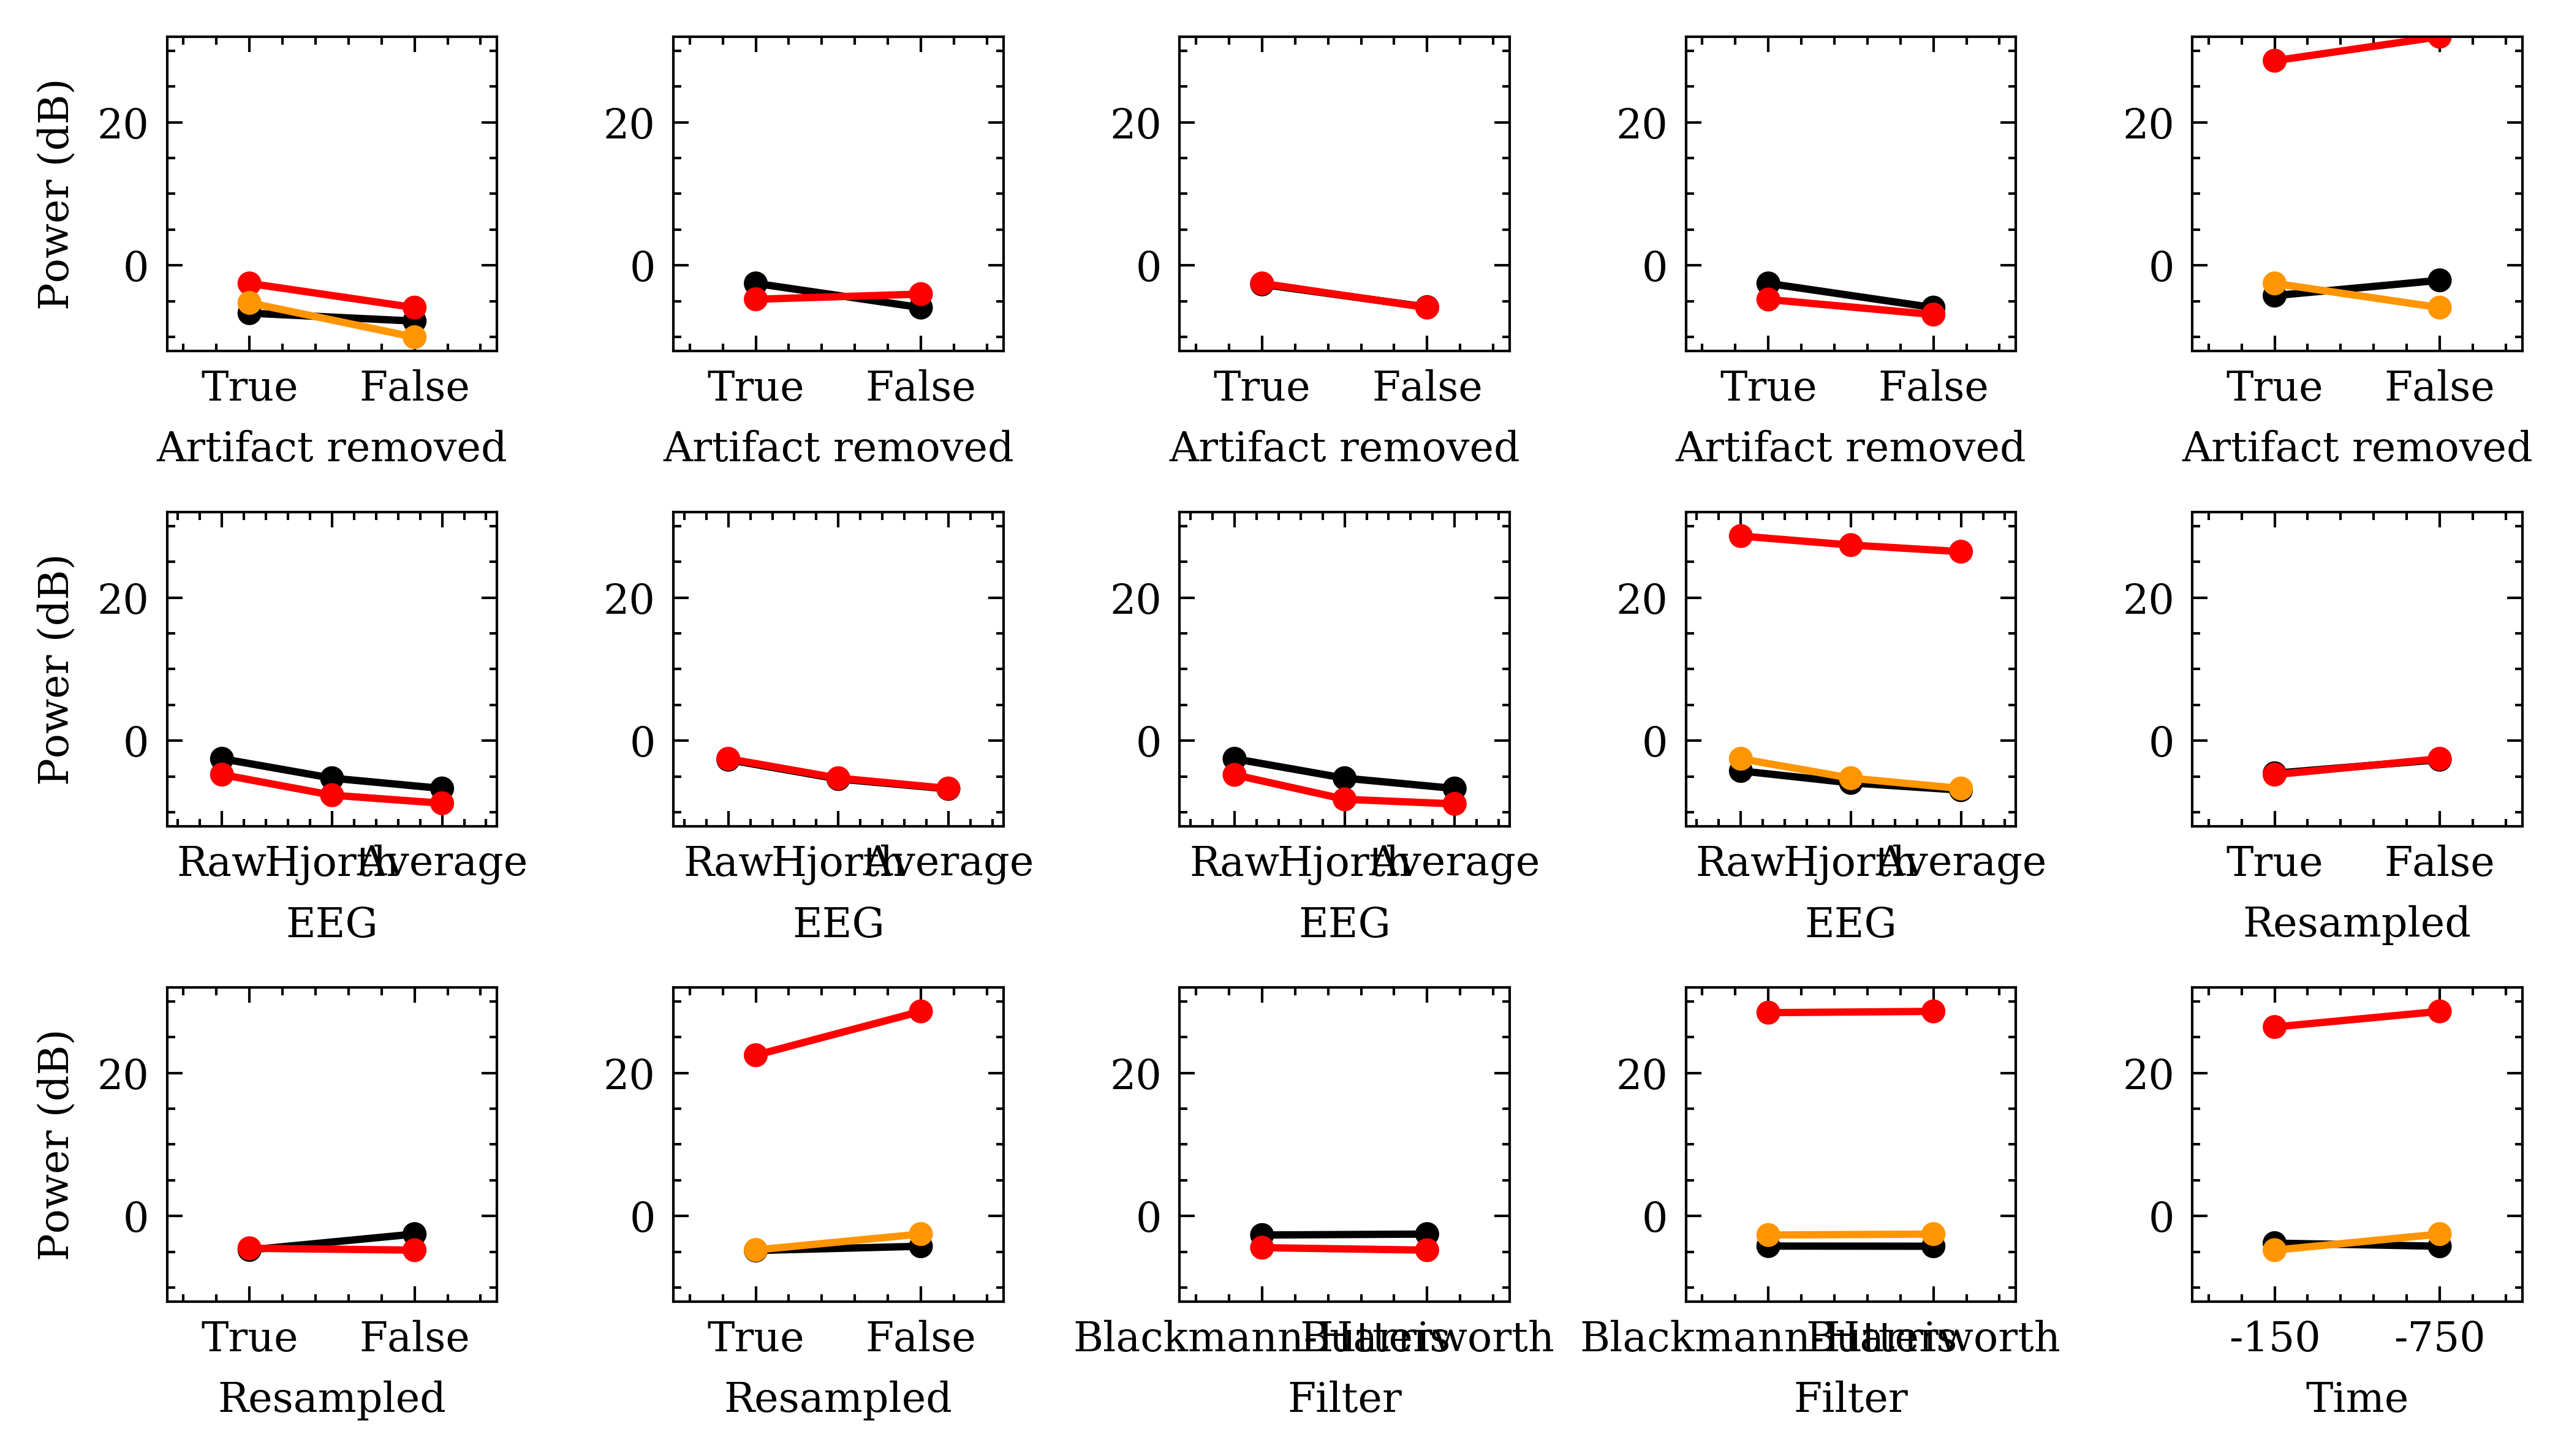

In [9]:
combs = list(combinations(list(def_values_power.keys()), 2))
df_power2 = df_power[df_power['Dataset'] == 'TMS-EEG']
df_power2 = df_power2[df_power2['Band'] == 'Mu']
df_power2 = df_power2[df_power2['sub'] == 'sub21']
i = 0
j = 0
with plt.style.context(['science-raquib']):
    f, axs = plt.subplots(3,5,figsize=(7,4))
    for comb in tqdm(combs):
        df_power3 = df_power2.copy()
        for key, value in def_values_power.items():
            if key not in comb:
                df_power3 = df_power3[df_power3[key] == value]
        print("Plotting in ({}, {}): {}, shape: {}, unique1: {}, unique2: {}".format(i, j, comb, df_power3.shape, df_power3[comb[0]].unique(), df_power3[comb[1]].unique()))
        df_power3 = df_power3[[comb[0], comb[1], 'value']]
        sns.pointplot(x=comb[0], y="value", hue=comb[1], data=df_power3, errwidth=0, ax=axs[i,j], order=hue_order_power[comb[0]])
        axs[i, j].get_legend().remove()
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')

        else:
            axs[i, j].set_ylabel('')
        axs[i, j].set_xlabel(comb[0])
        axs[i, j].set_ylim([-12, 32])
        j = j + 1
        if j > 4:
            i = i + 1
            j = 0
    plt.tight_layout()

# Plot histogram of phases

Artifact removed, Band: Theta, Options: [ True False]
Artifact removed, Band: Mu, Options: [ True False]
Artifact removed, Band: Beta, Options: [ True False]
Artifact removed, Band: Gamma, Options: [ True False]
EEG, Band: Theta, Options: ['Raw' 'Hjorth' 'Average']
EEG, Band: Mu, Options: ['Raw' 'Hjorth' 'Average']
EEG, Band: Beta, Options: ['Raw' 'Hjorth' 'Average']
EEG, Band: Gamma, Options: ['Raw' 'Hjorth' 'Average']


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Filter, Band: Theta, Options: ['Blackmann-Harris' 'Butterworth']
Filter, Band: Mu, Options: ['Blackmann-Harris' 'Butterworth']
Filter, Band: Beta, Options: ['Blackmann-Harris' 'Butterworth']
Filter, Band: Gamma, Options: ['Blackmann-Harris' 'Butterworth']



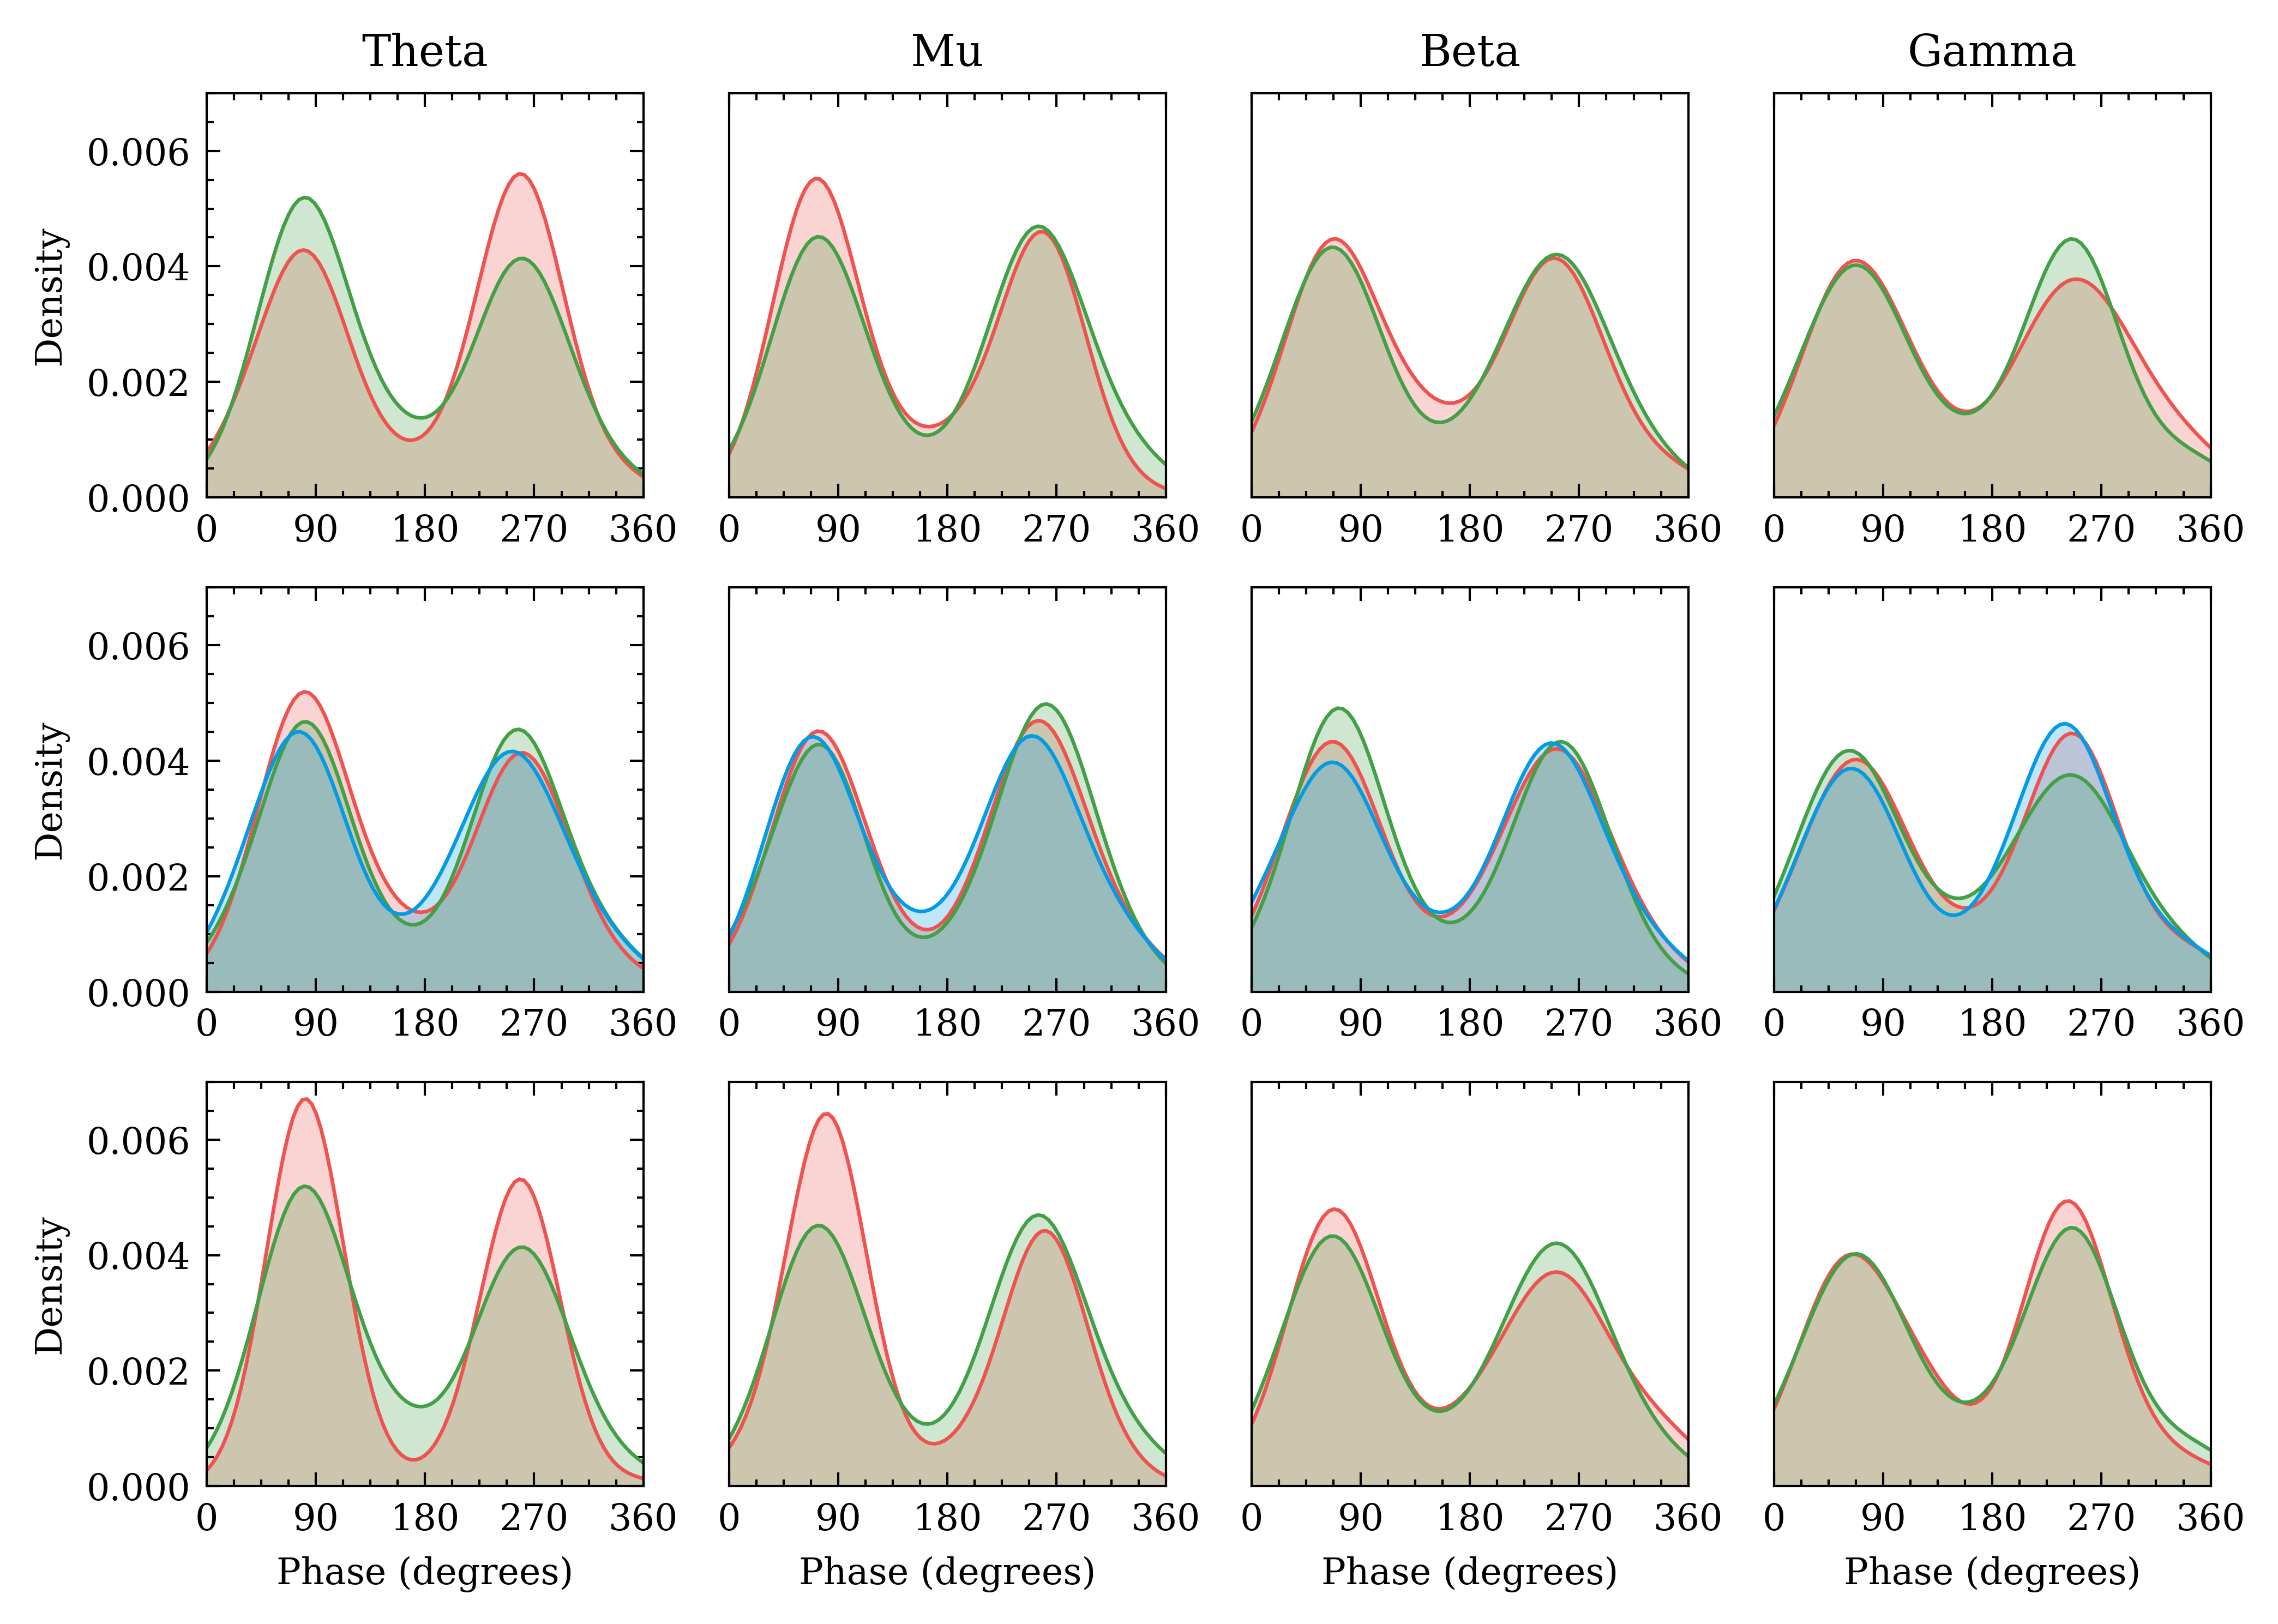

In [10]:
df_phase2 = df_phase[df_phase['Dataset'] == 'TMS-EEG']
df_phase2 = df_phase2[df_phase2['sub'] == 'sub21']

with plt.style.context(['science-raquib']):
    colors = ['#EF5350', '#43A047', '#039BE5']
    f, axs = plt.subplots(3, 4, figsize=(7,5))
    i = 0
    j = 0
    color_ind = 0
    for variable in tqdm(list(def_values_phase.keys())):
        df_phase3 = df_phase2.copy()
        for key, value in def_values_phase.items():
                if key != variable:
                    df_phase3 = df_phase3[df_phase3[key] == value]
        for band in ['Theta', 'Mu', 'Beta', 'Gamma']:
            print('{}, Band: {}, Options: {}'.format(variable, band, df_phase3[variable].unique()))
            for option in df_phase3[variable].unique():
                df_phase4 = df_phase3[df_phase3['Band'] == band]
                df_phase4 = df_phase4[df_phase4[variable] == option]
                sns.distplot(df_phase4['value'], hist=False, color=colors[color_ind], kde_kws={"shade": True}, ax=axs[i, j])
                color_ind = color_ind + 1
                if i == 2:
                    axs[i, j].set_xlabel('Phase (degrees)')
                else:
                    axs[i, j].set_xlabel('')
                axs[i, j].set_xlim([0, 360])
                axs[i, j].set_ylim([0, 0.007])
                axs[i, j].set_xticks([0, 90, 180, 270, 360])
            if i == 0:
                axs[i, j].set_title(band)
            if j == 0:
                axs[i, j].set_ylabel('Density')
            else:
                axs[i, j].get_yaxis().set_visible(False)
            j = j + 1
            if j > 3:
                j = 0
            color_ind = 0
        i = i + 1
        
    plt.tight_layout()

# Box plot for phases

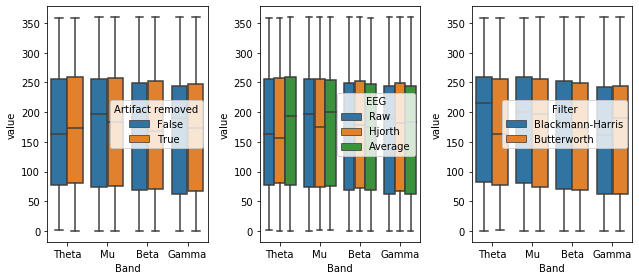

In [11]:
f, axs = plt.subplots(1,3,figsize=(9,4))
df_phase2 = df_phase[df_phase['Dataset'] == 'TMS-EEG']

# Artifact removal
df_phase3 = df_phase2[df_phase2['EEG'] == 'Raw']
df_phase3 = df_phase3[df_phase3['Filter'] == 'Butterworth']
sns.boxplot(x="Band", y="value", hue='Artifact removed', data=df_phase3, ax=axs[0])

# EEG transform
df_phase3 = df_phase2[df_phase2['Artifact removed'] == False]
df_phase3 = df_phase3[df_phase3['Filter'] == 'Butterworth']
sns.boxplot(x="Band", y="value", hue='EEG', data=df_phase3, ax=axs[1])

# Filter
df_phase3 = df_phase2[df_phase2['Artifact removed'] == False]
df_phase3 = df_phase3[df_phase3['EEG'] == 'Raw']
sns.boxplot(x="Band", y="value", hue='Filter', data=df_phase3, ax=axs[2])

plt.tight_layout()

# Dataset 2

## PSDs across trial

In [ ]:
df_power2 = df_power[df_power['Dataset'] == 'VEP-EEG']
df_power2 = df_power2[df_power2['sub'] == df_power2['sub'].unique()[10]]
df_power2 = df_power2[df_power2['Band'] == 'Beta']
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(2, 2, figsize=(5,3))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power_d2.keys())):
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power_d2.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        df_power3 = df_power3[['trial', 'value', variable]]
        sns.lineplot(x="trial", y="value", hue=variable, data=df_power3, ax=axs[i, j], hue_order=hue_order_power[variable], palette=sns.color_palette("Set1", df_power3[variable].nunique()))
        # axs[i, j].set_ylim([-25,35])
        # plt.setp(axs[i, j].lines, color='k')
        # axs[i, j].get_legend().remove()
        axs[i,j].set_xlabel('Trial')
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
            axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 1:
            j = 0
            i = i + 1

    plt.tight_layout()

## Box plots - PSD

--------------
EEG
--------------
Performing Filter = Butterworth for constant EEG, shape = (7704, 21)
Performing Time = -750 for constant EEG, shape = (3852, 21)
Performing Method = Welch for constant EEG, shape = (1284, 21)
--------------
Filter
--------------
Performing EEG = Raw for constant Filter, shape = (5136, 21)
Performing Time = -750 for constant Filter, shape = (2568, 21)
Performing Method = Welch for constant Filter, shape = (856, 21)
--------------
Time
--------------
Performing EEG = Raw for constant Time, shape = (5136, 21)
Performing Filter = Butterworth for constant Time, shape = (2568, 21)
Performing Method = Welch for constant Time, shape = (856, 21)
--------------
Method
--------------
Performing EEG = Raw for constant Method, shape = (5136, 21)
Performing Filter = Butterworth for constant Method, shape = (2568, 21)
Performing Time = -750 for constant Method, shape = (1284, 21)



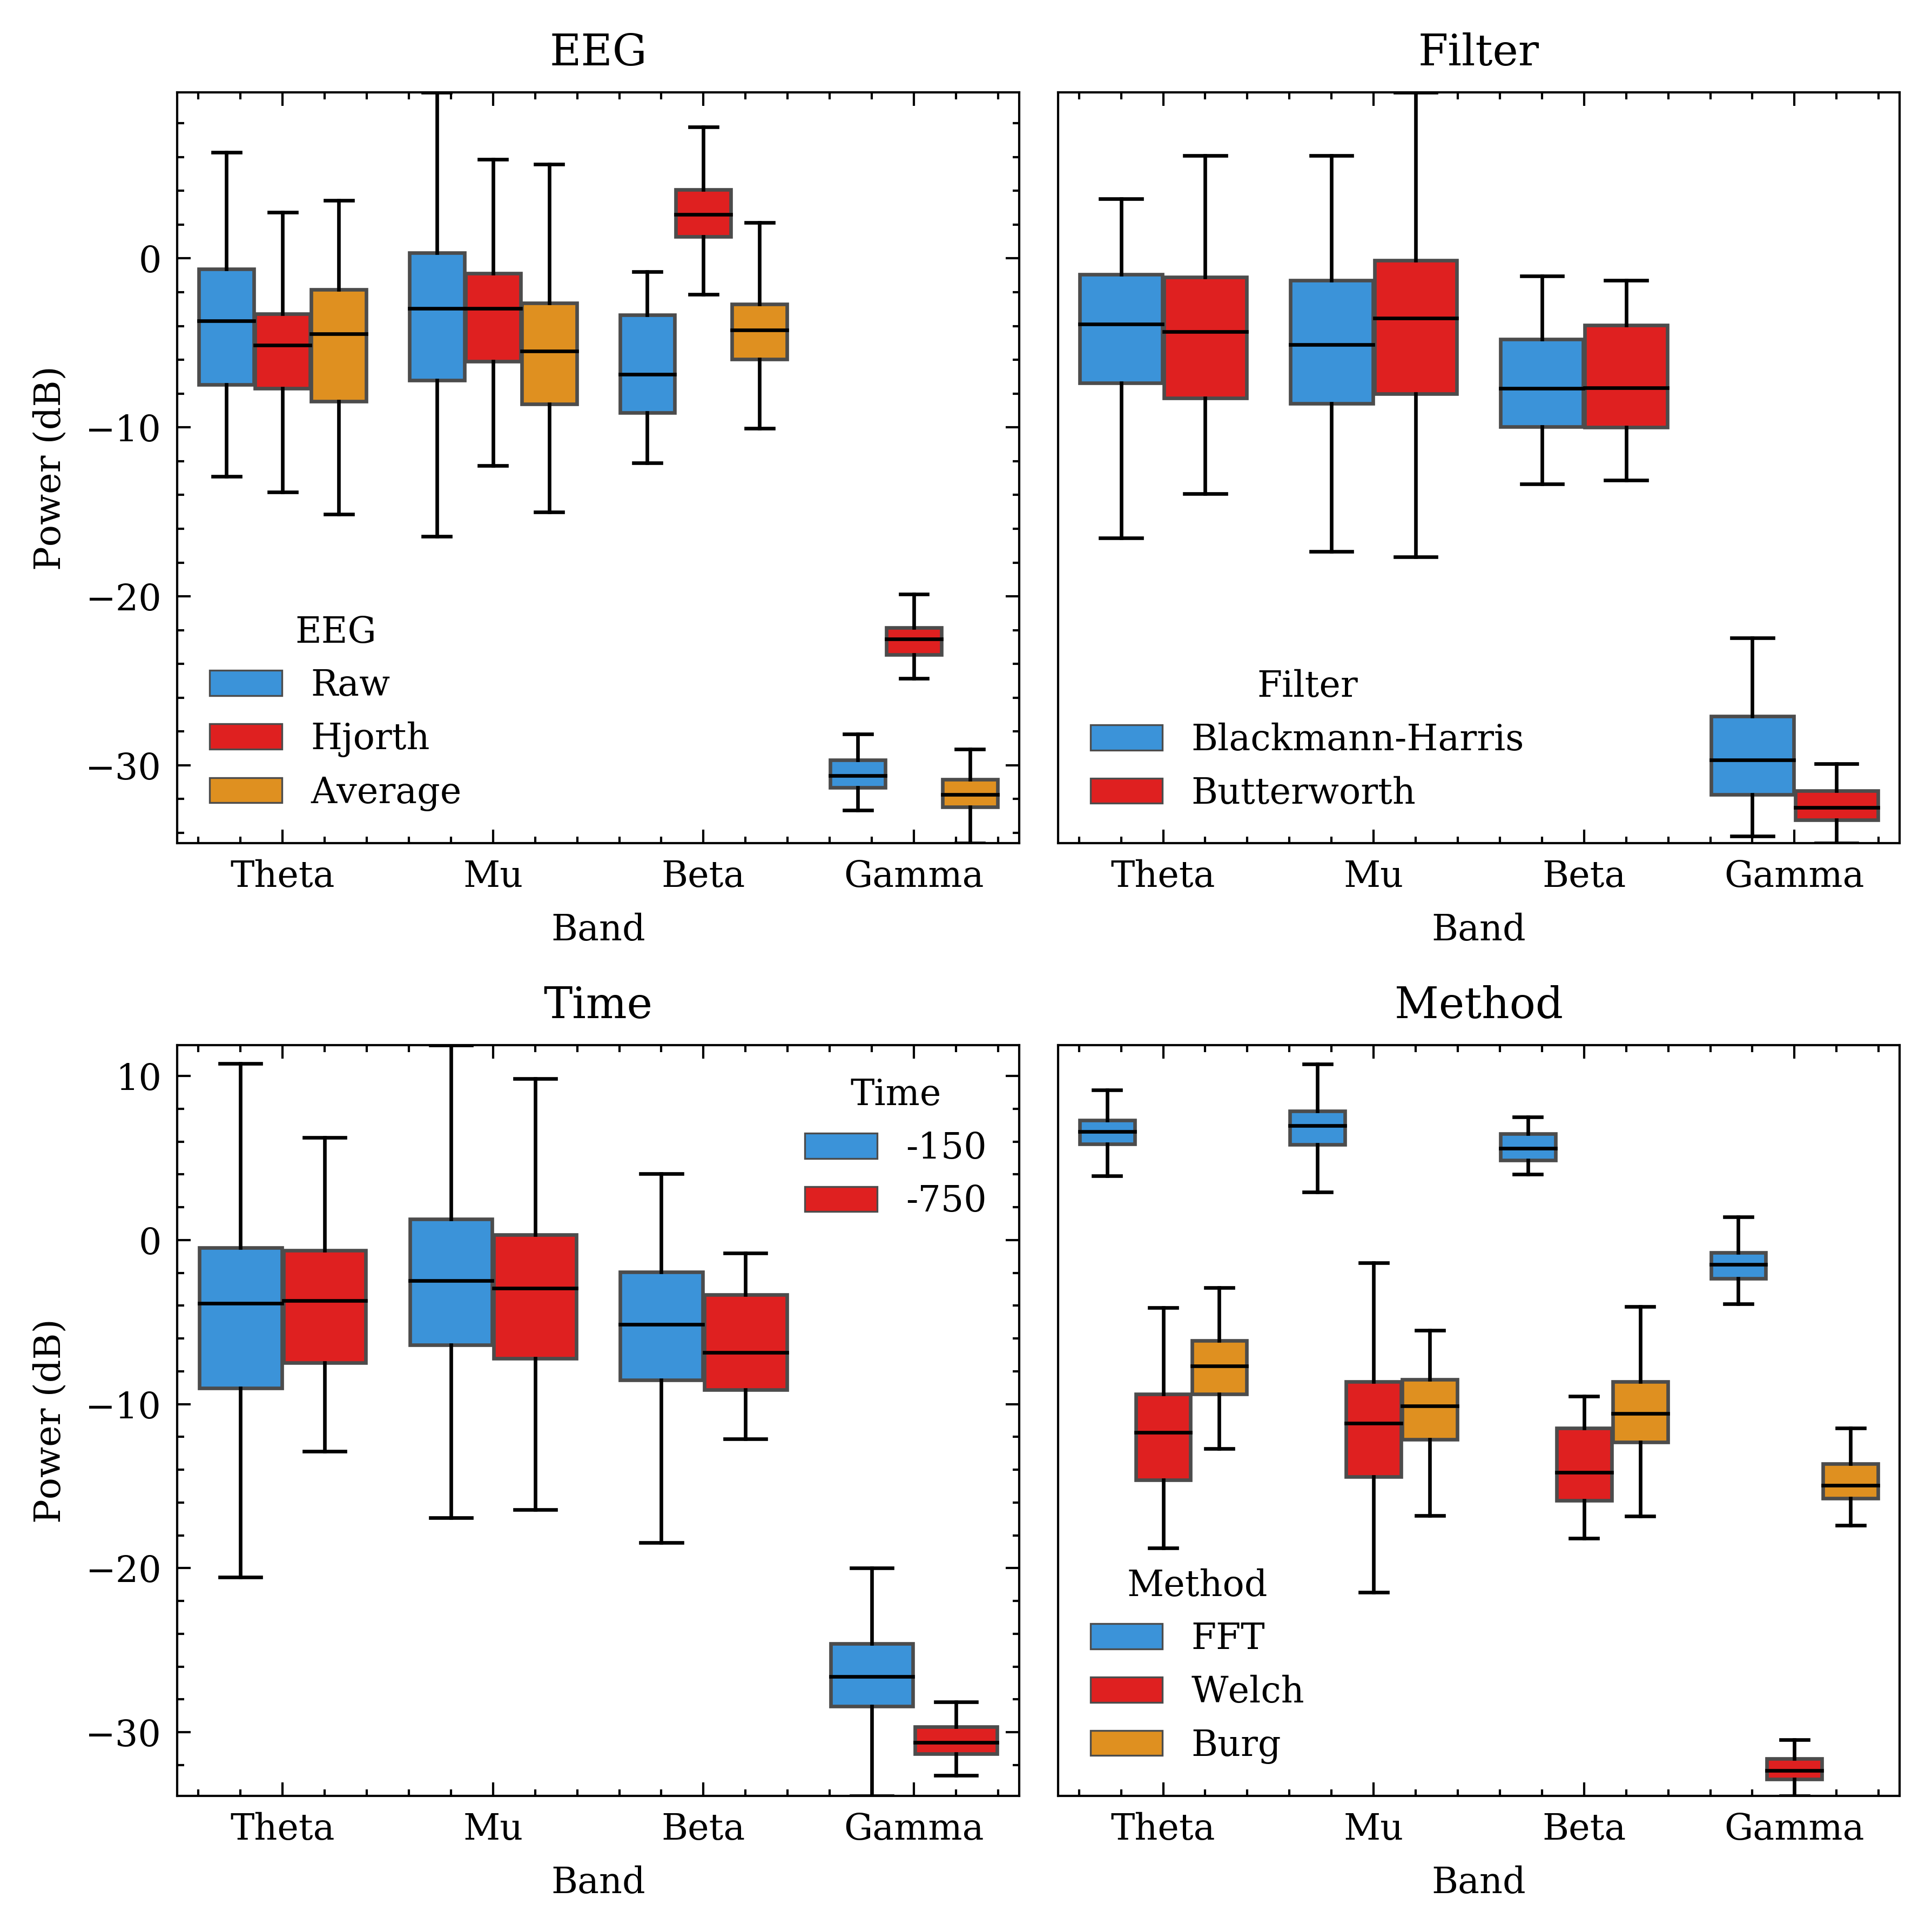

In [195]:
df_power2 = df_power[df_power['Dataset'] == 'VEP-EEG']
df_power2 = df_power2[df_power2['sub'] == df_power2['sub'].unique()[10]]
with plt.style.context(['science-raquib2']):
    f, axs = plt.subplots(2,2,figsize=(6, 6))
    # f, axs = plt.subplots(2,3,figsize=(13, 8))
    i = 0
    j = 0
    for variable in tqdm(list(def_values_power_d2.keys())):    
        df_power3 = df_power2
        print('--------------')
        print(variable)
        print('--------------')
        for key, value in def_values_power_d2.items():
            if key != variable:
                df_power3 = df_power3[df_power3[key] == value]
                print('Performing {} = {} for constant {}, shape = {}'.format(key, value, variable, df_power3.shape))

        sns.boxplot(x="Band", y="value", hue=variable, data=df_power3, ax=axs[i, j], fliersize=0, hue_order=hue_order_power_d2[variable])
        # axs[i, j].set_ylim([-25,30])
        plt.setp(axs[i, j].lines, color='k')
        axs[i, j].set_title(variable)
        # axs[i, j].get_legend().remove()
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')
        else:
            axs[i, j].set_ylabel('')
            axs[i, j].get_yaxis().set_ticks([])
        j = j + 1
        if j > 1:
            j = 0
            i = i + 1

    plt.tight_layout()

## Interaction plot - PSD

Plotting in (0, 0): ('EEG', 'Filter'), shape: (642, 21), unique1: ['Hjorth' 'Raw' 'Average'], unique2: ['Butterworth' 'Blackmann-Harris']
Plotting in (0, 1): ('EEG', 'Time'), shape: (642, 21), unique1: ['Hjorth' 'Raw' 'Average'], unique2: [-750 -150]
Plotting in (1, 0): ('EEG', 'Method'), shape: (963, 21), unique1: ['Hjorth' 'Raw' 'Average'], unique2: ['FFT' 'Welch' 'Burg']
Plotting in (1, 1): ('Filter', 'Time'), shape: (428, 21), unique1: ['Butterworth' 'Blackmann-Harris'], unique2: [-750 -150]
Plotting in (2, 0): ('Filter', 'Method'), shape: (642, 21), unique1: ['Butterworth' 'Blackmann-Harris'], unique2: ['FFT' 'Welch' 'Burg']
Plotting in (2, 1): ('Time', 'Method'), shape: (642, 21), unique1: [-750 -150], unique2: ['FFT' 'Welch' 'Burg']



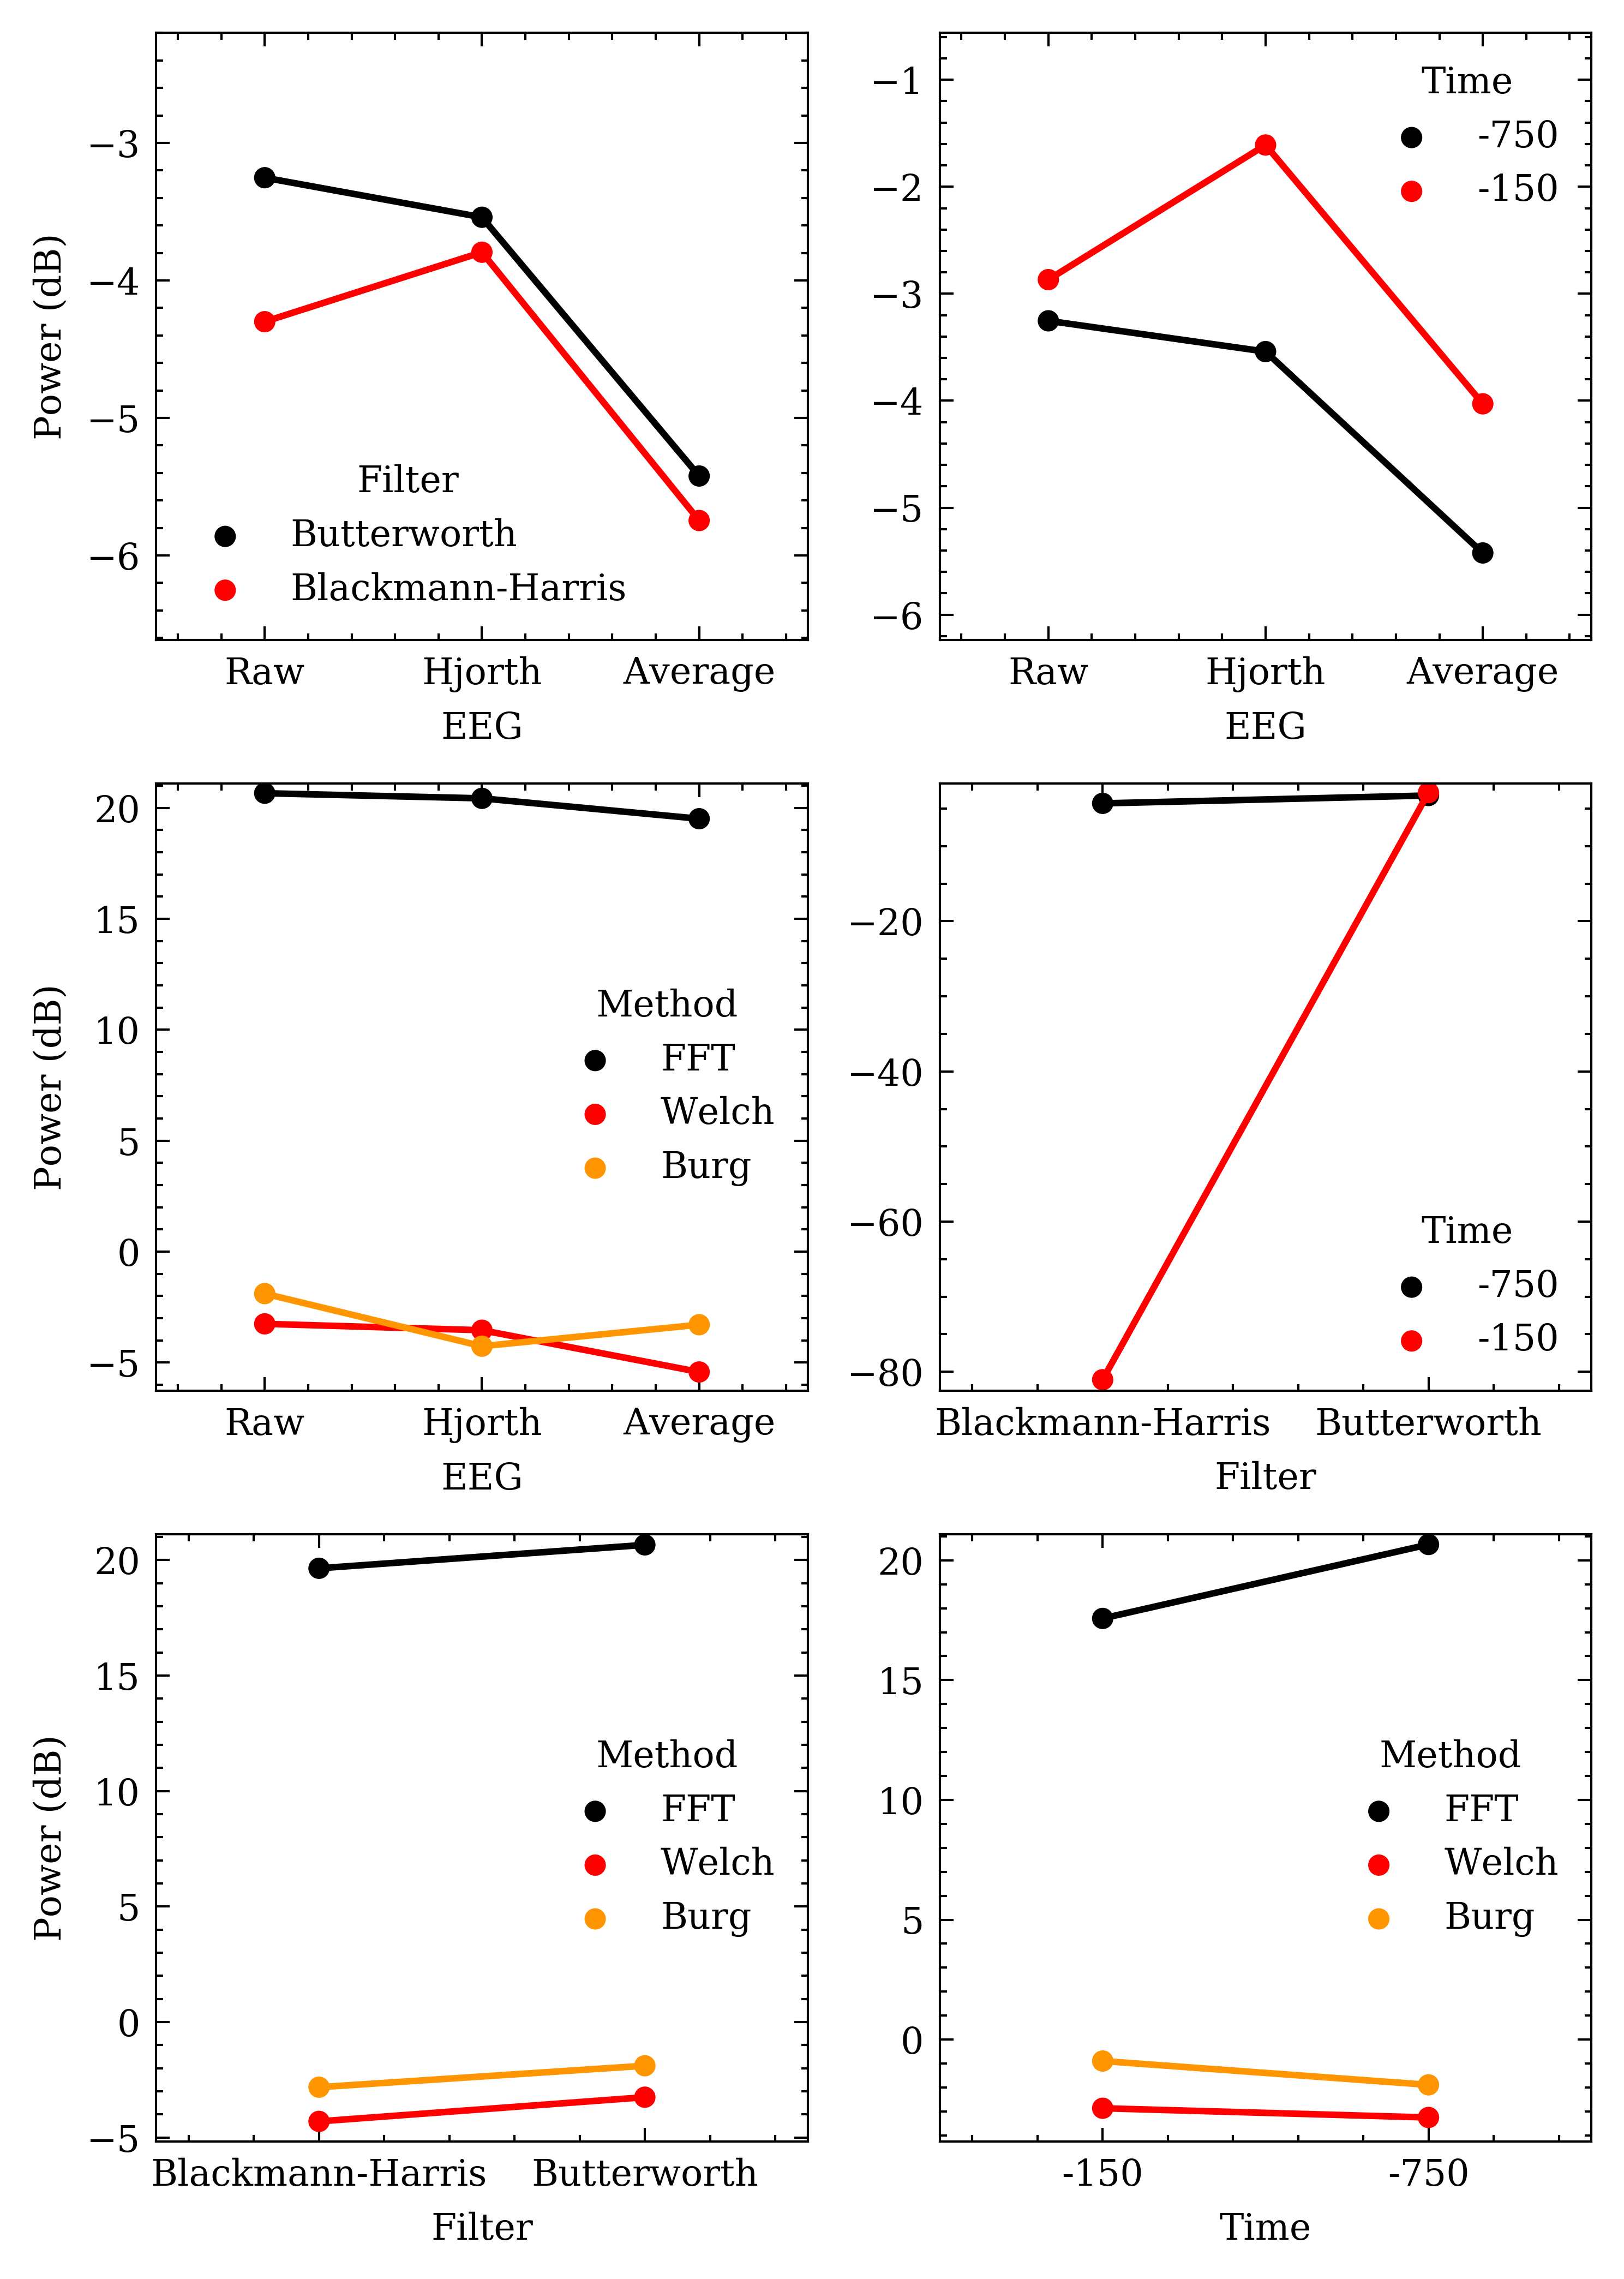

In [198]:
combs = list(combinations(list(def_values_power_d2.keys()), 2))
df_power2 = df_power[df_power['Dataset'] == 'VEP-EEG']
df_power2 = df_power2[df_power2['Band'] == 'Mu']
df_power2 = df_power2[df_power2['sub'] == df_power2['sub'].unique()[10]]
i = 0
j = 0
with plt.style.context(['science-raquib']):
    f, axs = plt.subplots(3,2,figsize=(5,7))
    for comb in tqdm(combs):
        df_power3 = df_power2.copy()
        for key, value in def_values_power_d2.items():
            if key not in comb:
                df_power3 = df_power3[df_power3[key] == value]
        print("Plotting in ({}, {}): {}, shape: {}, unique1: {}, unique2: {}".format(i, j, comb, df_power3.shape, df_power3[comb[0]].unique(), df_power3[comb[1]].unique()))
        df_power3 = df_power3[[comb[0], comb[1], 'value']]
        sns.pointplot(x=comb[0], y="value", hue=comb[1], data=df_power3, errwidth=0, ax=axs[i,j], order=hue_order_power[comb[0]])
        # axs[i, j].get_legend().remove()
        if j == 0:
            axs[i, j].set_ylabel('Power (dB)')

        else:
            axs[i, j].set_ylabel('')
        axs[i, j].set_xlabel(comb[0])
        # axs[i, j].set_ylim([-12, 32])
        j = j + 1
        if j > 1:
            i = i + 1
            j = 0
    plt.tight_layout()

## Histogram - phases

EEG, Band: Theta, Options: ['Hjorth' 'Raw' 'Average']
EEG, Band: Mu, Options: ['Hjorth' 'Raw' 'Average']
EEG, Band: Beta, Options: ['Hjorth' 'Raw' 'Average']
EEG, Band: Gamma, Options: ['Hjorth' 'Raw' 'Average']
Filter, Band: Theta, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Mu, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Beta, Options: ['Butterworth' 'Blackmann-Harris']
Filter, Band: Gamma, Options: ['Butterworth' 'Blackmann-Harris']



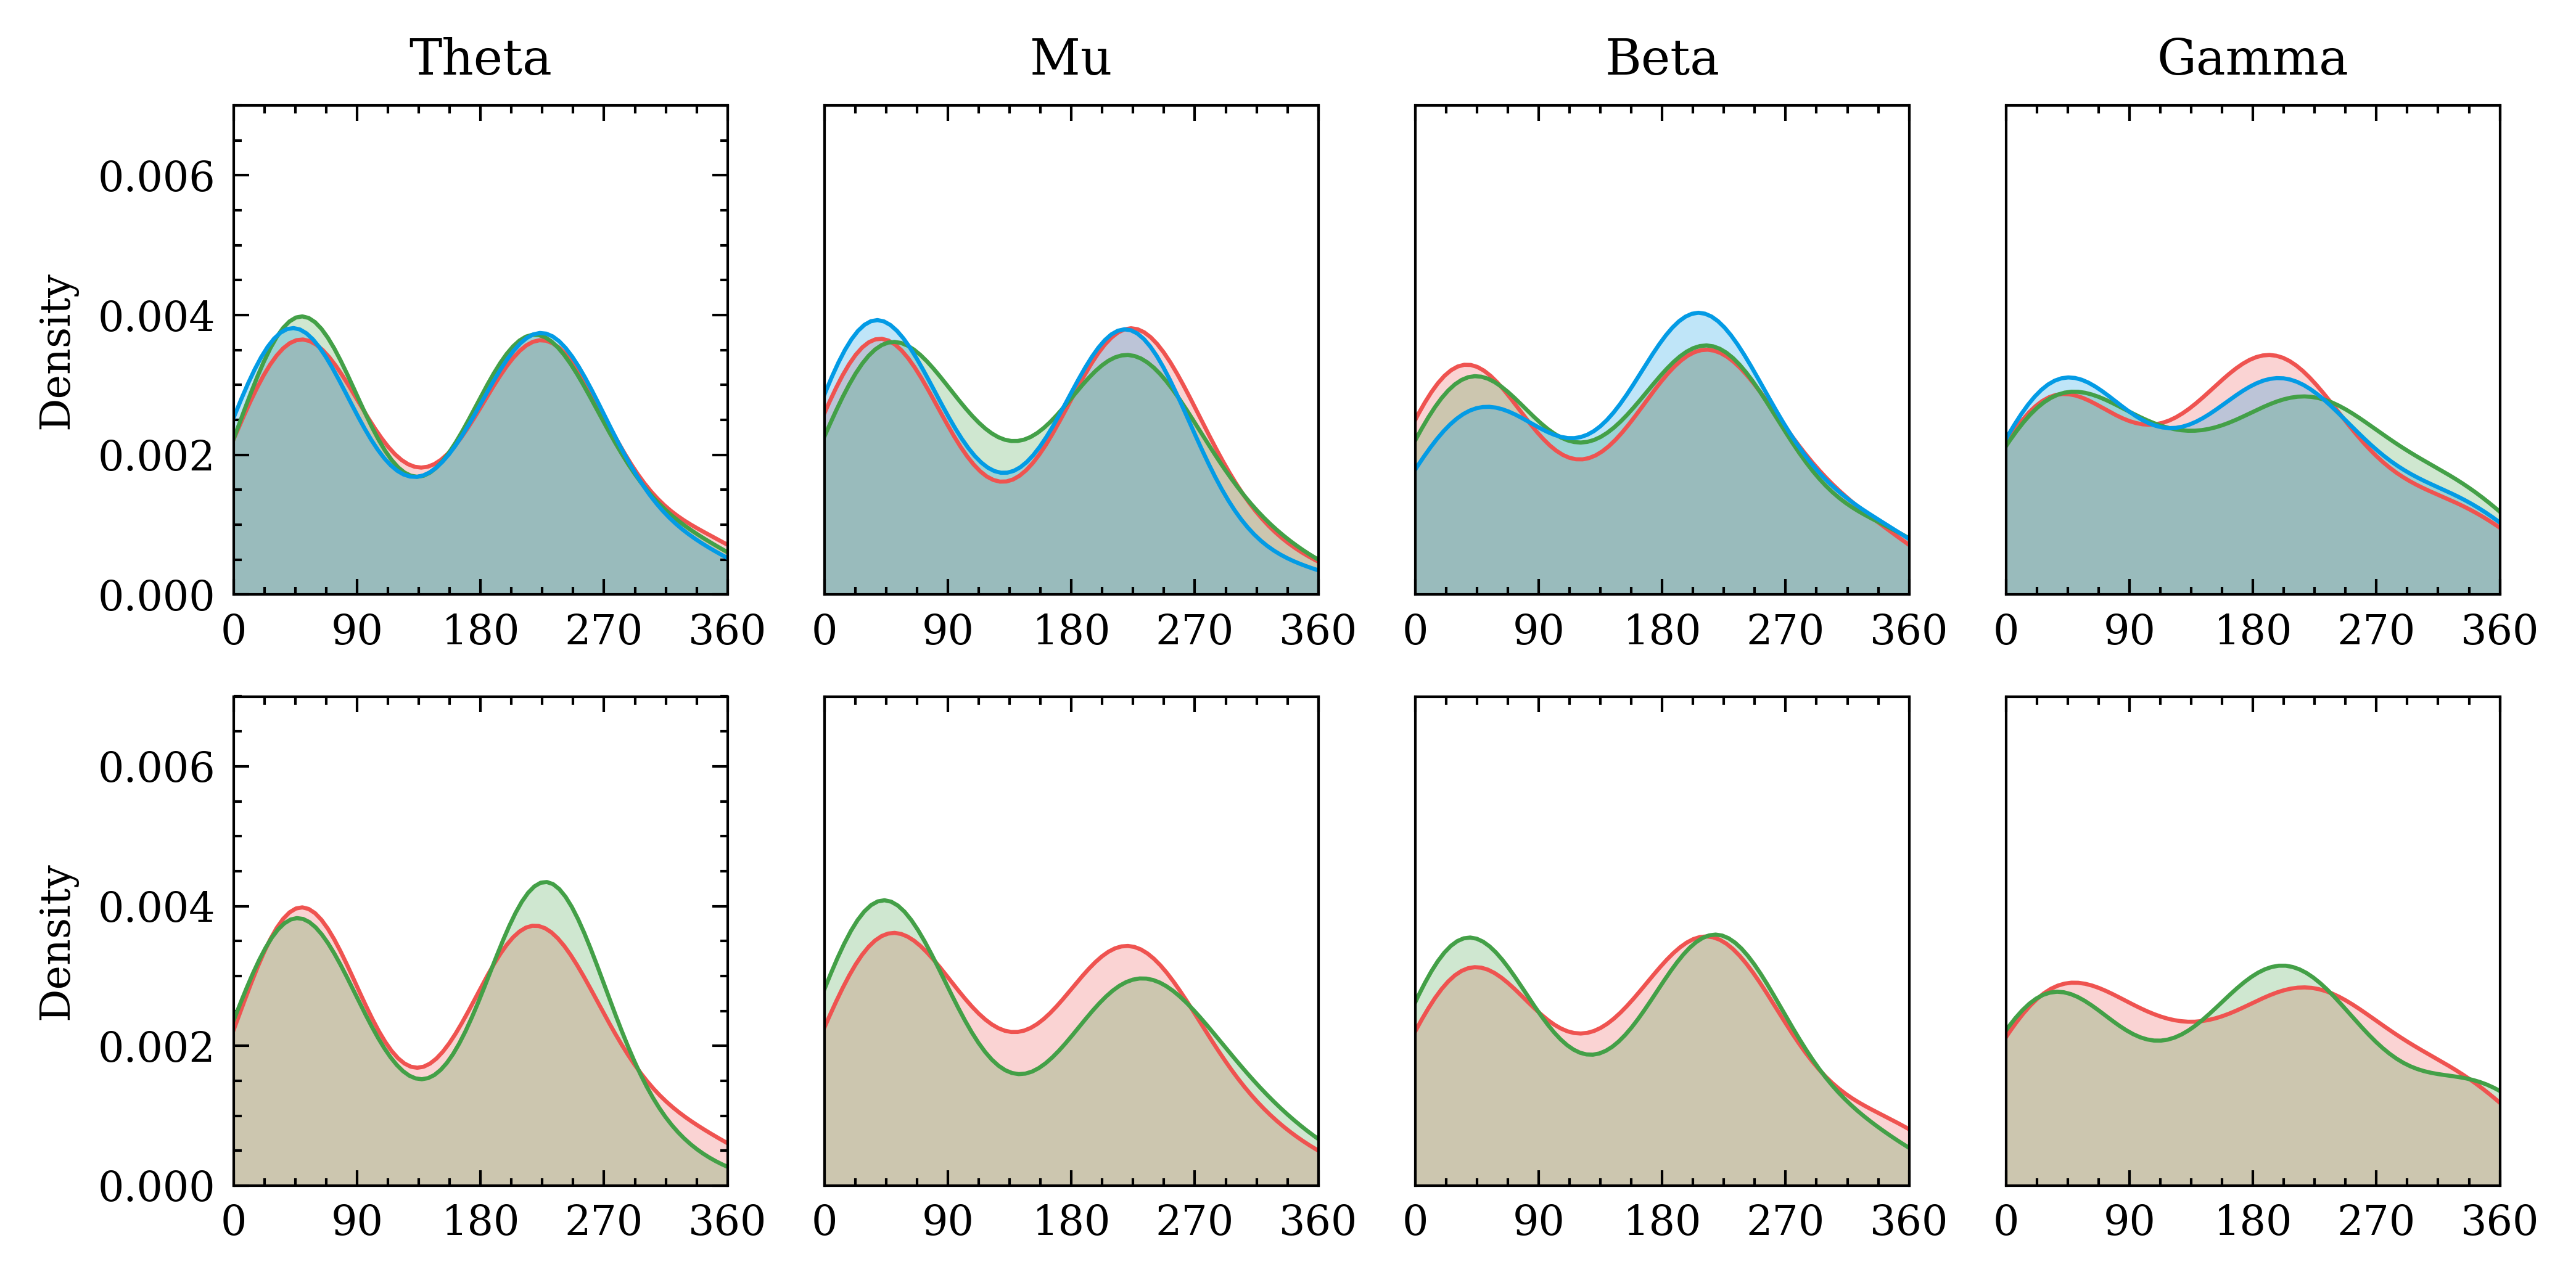

In [192]:
df_phase2 = df_phase[df_phase['Dataset'] == 'VEP-EEG']
df_phase2 = df_phase2[df_phase2['sub'] == df_phase2['sub'].unique()[10]]

with plt.style.context(['science-raquib']):
    colors = ['#EF5350', '#43A047', '#039BE5']
    f, axs = plt.subplots(2, 4, figsize=(7,3.5))
    i = 0
    j = 0
    color_ind = 0
    for variable in tqdm(list(def_values_phase_d2.keys())):
        df_phase3 = df_phase2.copy()
        for key, value in def_values_phase_d2.items():
                if key != variable:
                    df_phase3 = df_phase3[df_phase3[key] == value]
        for band in ['Theta', 'Mu', 'Beta', 'Gamma']:
            print('{}, Band: {}, Options: {}'.format(variable, band, df_phase3[variable].unique()))
            for option in df_phase3[variable].unique():
                df_phase4 = df_phase3[df_phase3['Band'] == band]
                df_phase4 = df_phase4[df_phase4[variable] == option]
                sns.distplot(df_phase4['value'], hist=False, color=colors[color_ind], kde_kws={"shade": True}, ax=axs[i, j])
                color_ind = color_ind + 1
                if i == 2:
                    axs[i, j].set_xlabel('Phase (degrees)')
                else:
                    axs[i, j].set_xlabel('')
                axs[i, j].set_xlim([0, 360])
                axs[i, j].set_ylim([0, 0.007])
                axs[i, j].set_xticks([0, 90, 180, 270, 360])
            if i == 0:
                axs[i, j].set_title(band)
            if j == 0:
                axs[i, j].set_ylabel('Density')
            else:
                axs[i, j].get_yaxis().set_visible(False)
            j = j + 1
            if j > 3:
                j = 0
            color_ind = 0
        i = i + 1
        
    plt.tight_layout()